In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm
###IE###
%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images , pre_hard_skeletonize , pre_soft_skeletonize
from utils.preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from utils.logger import save_full_report
from trainer import trainer
###SS###

# Training

In [2]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "use_cldice" : True,
    "k":40,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.001,
    "momentum" : 0.9,
    "epcohs":100,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "loss_type":"dice loss",
    "alpha":0.75,
    "beta":0.25,
    "gamma":1.00,
    "loss_coefs":{"CE":0.4,"Second":0.3,"clDice":0.3},
    "output_base_path" : "./outputs",
    "name" : "Attention7-clDice"
}
class_map = {
    1: '1',2: '2', 3: '3',4: '4',
    5: '5',6: '6',7: '7',8: '8',
    9: '9',10: '9a',11: '10',12: '10a',
    13: '11',14: '12',15: '12a',16: '13',
    17: '14',18: '14a',19: '15',20: '16',
    21: '16a',22: '16b',23: '16c',
    24: '12b',25: '14b'
}
losses_keys = ["total loss","CE loss",args["loss_type"],"CL-Dice Loss"]

In [3]:
# pre_soft_skeletonize(args["base_path"],output_path=args["base_path"],batch_size=10,k=40)

In [4]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ToTensorV2()],
    additional_targets={
        'mask_skeleton': 'mask'
    }
)
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()],
    additional_targets={
        'mask_skeleton': 'mask'
    }    
)
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None

In [5]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images)
valid_ds = UnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [6]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [7]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
recorder = HistoryRecorder(losses_keys=losses_keys,class_maps =class_map)
trainer(args,recorder,model,optimizer,loss_fn,train_loader,valid_loader)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26
loss is set to dice


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (0)
total loss : 1.1527168065309525 - CE loss : 0.9151617586612701 - dice loss : -0.003922918662428856
CL-Dice Loss : 0.24147796630859375 - 
train avg metrics for epoch 0 :
avg dice : 0.009012584394238162 - avg precision : 0.010248953994596377 - avg recall : 0.026729021879582433
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0)
total loss : 0.6591664046049118 - CE loss : 0.4332500293850899 - dice loss : -0.004146571375895291
CL-Dice Loss : 0.23006295189261436 - 
valid avg metrics for epoch 0 :
avg dice : 0.01004865337651719 - avg precision : 0.014172860634280368 - avg recall : 0.009958494199818233
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (1)
total loss : 0.4015421372652054 - CE loss : 0.20578936375677587 - dice loss : -0.009557611919008195
CL-Dice Loss : 0.20531038731336593 - 
train avg metrics for epoch 1 :
avg dice : 0.014749353878289424 - avg precision : 0.020778810754418373 - avg recall : 0.018973523740423843
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (1)
total loss : 0.29218565821647646 - CE loss : 0.10696552954614162 - dice loss : -0.014367114473134279
CL-Dice Loss : 0.19958724230527877 - 
valid avg metrics for epoch 1 :
avg dice : 0.015418322422023411 - avg precision : 0.016972585916519164 - avg recall : 0.02143032775260508
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (2)
total loss : 0.2340444552898407 - CE loss : 0.08342165745794773 - dice loss : -0.023437004974111914
CL-Dice Loss : 0.17405980259180068 - 
train avg metrics for epoch 2 :
avg dice : 0.026004419343522375 - avg precision : 0.04125699669122696 - avg recall : 0.03408260729513131
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (2)
total loss : 0.1969643458724022 - CE loss : 0.07643933407962322 - dice loss : -0.034010542742908004
CL-Dice Loss : 0.15453555509448053 - 
valid avg metrics for epoch 2 :
avg dice : 0.04618014137300647 - avg precision : 0.06065308332443237 - avg recall : 0.056646297443658115
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (3)
total loss : 0.14778800256550312 - CE loss : 0.06599205538630486 - dice loss : -0.04648170132189989
CL-Dice Loss : 0.12827764831483365 - 
train avg metrics for epoch 3 :
avg dice : 0.060513141526463726 - avg precision : 0.0942644602060318 - avg recall : 0.07708228296571179
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (3)
total loss : 0.14248652905225753 - CE loss : 0.0670460494235158 - dice loss : -0.04905443824827671
CL-Dice Loss : 0.12449491880834103 - 
valid avg metrics for epoch 3 :
avg dice : 0.07930132290387593 - avg precision : 0.09684813559055329 - avg recall : 0.09622539814561605
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4)
total loss : 0.10744416877627373 - CE loss : 0.05885433595627546 - dice loss : -0.06501925587654114
CL-Dice Loss : 0.1136090887337923 - 
train avg metrics for epoch 4 :
avg dice : 0.10509731095327977 - avg precision : 0.12371321260929108 - avg recall : 0.11733454201370477
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4)
total loss : 0.11222014259546995 - CE loss : 0.06358631160110235 - dice loss : -0.06266645770519971
CL-Dice Loss : 0.11130028963088989 - 
valid avg metrics for epoch 4 :
avg dice : 0.10521561338138989 - avg precision : 0.15706177532672883 - avg recall : 0.11181992993922904
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (5)
total loss : 0.07819786094129086 - CE loss : 0.05490196324884891 - dice loss : -0.08081735864281654
CL-Dice Loss : 0.10411325626075268 - 
train avg metrics for epoch 5 :
avg dice : 0.14068463504358172 - avg precision : 0.14702860236167908 - avg recall : 0.15367361068725585
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (5)
total loss : 0.08349370881915093 - CE loss : 0.05917393174022436 - dice loss : -0.07766140513122081
CL-Dice Loss : 0.10198118239641189 - 
valid avg metrics for epoch 5 :
avg dice : 0.15038162263148686 - avg precision : 0.15826529890298843 - avg recall : 0.15975396416150034
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (6)
total loss : 0.05984021723270416 - CE loss : 0.05204521767795086 - dice loss : -0.09286726623773575
CL-Dice Loss : 0.10066226571798324 - 
train avg metrics for epoch 6 :
avg dice : 0.15914498850747028 - avg precision : 0.16199930012226105 - avg recall : 0.17631385423243046
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (6)
total loss : 0.06843131352216006 - CE loss : 0.056557558849453925 - dice loss : -0.08816732615232467
CL-Dice Loss : 0.10004108175635337 - 
valid avg metrics for epoch 6 :
avg dice : 0.16624189630189204 - avg precision : 0.17854885816574095 - avg recall : 0.17852153062820433
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (7)
total loss : 0.04548916403204203 - CE loss : 0.050648095048964024 - dice loss : -0.10182176351547241
CL-Dice Loss : 0.09666283272206783 - 
train avg metrics for epoch 7 :
avg dice : 0.17685375943008702 - avg precision : 0.17430955722928046 - avg recall : 0.191481652057264
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (7)
total loss : 0.057276155799627304 - CE loss : 0.05504580829292536 - dice loss : -0.0951720654964447
CL-Dice Loss : 0.09740241318941116 - 
valid avg metrics for epoch 7 :
avg dice : 0.18618897769638132 - avg precision : 0.1963191431760788 - avg recall : 0.19823504135012626
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (8)
total loss : 0.02319539412856102 - CE loss : 0.04749610126018524 - dice loss : -0.11587473653256893
CL-Dice Loss : 0.09157402902841567 - 
train avg metrics for epoch 8 :
avg dice : 0.20423306162425156 - avg precision : 0.21719878882169724 - avg recall : 0.21980924531511847
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (8)
total loss : 0.04647985957562924 - CE loss : 0.055405354127287865 - dice loss : -0.104648457467556
CL-Dice Loss : 0.0957229632884264 - 
valid avg metrics for epoch 8 :
avg dice : 0.20166428934354097 - avg precision : 0.22217756599187852 - avg recall : 0.20986957632820122
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (9)
total loss : 0.018673535212874414 - CE loss : 0.047434075959026815 - dice loss : -0.12023841045796871
CL-Dice Loss : 0.091477869451046 - 
train avg metrics for epoch 9 :
avg dice : 0.21342436912047283 - avg precision : 0.20965759038925172 - avg recall : 0.22902906588977204
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (9)
total loss : 0.033916613645851613 - CE loss : 0.05299274604767561 - dice loss : -0.11126366145908832
CL-Dice Loss : 0.0921875298023224 - 
valid avg metrics for epoch 9 :
avg dice : 0.21679615795648804 - avg precision : 0.21503826707601548 - avg recall : 0.23002542512957005
1 => dice : 0.6287375688552856 p : 0.6834639310836792 , r : 0.5821255445480347
2 => dice : 0.6349974274635315 p : 0.7059532999992371 , r : 0.5770024657249451
3 => dice : 0.5700011253356934 p : 0.537761390209198 , r : 0.6063531041145325
4 => dice : 0.3144269585609436 p : 0.28379037976264954 , r : 0.3524787724018097
5 => dice : 0.6592458486557007 p : 

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (10)
total loss : 0.012711087055504323 - CE loss : 0.04651934450492263 - dice loss : -0.12442032419145108
CL-Dice Loss : 0.0906120665371418 - 
train avg metrics for epoch 10 :
avg dice : 0.22191810559524794 - avg precision : 0.21924621641635894 - avg recall : 0.2388132543489337
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (10)
total loss : 0.034409822337329386 - CE loss : 0.05204008053988218 - dice loss : -0.10964721217751502
CL-Dice Loss : 0.09201695434749127 - 
valid avg metrics for epoch 10 :
avg dice : 0.21470071082971207 - avg precision : 0.22333961620926857 - avg recall : 0.2273810915509239
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (11)
total loss : 0.002180086672306061 - CE loss : 0.044769485834985974 - dice loss : -0.13127324342727661
CL-Dice Loss : 0.0886838436126709 - 
train avg metrics for epoch 11 :
avg dice : 0.2340564138819145 - avg precision : 0.22928757339715958 - avg recall : 0.24967577012255787
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (11)
total loss : 0.017621013894677164 - CE loss : 0.04826462268829346 - dice loss : -0.12072637528181077
CL-Dice Loss : 0.09008276723325252 - 
valid avg metrics for epoch 11 :
avg dice : 0.24246326308733931 - avg precision : 0.24964872300624846 - avg recall : 0.24948503612540662
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (12)
total loss : -0.011322968602180482 - CE loss : 0.04270996514707804 - dice loss : -0.13789955832064152
CL-Dice Loss : 0.08386662386357785 - 
train avg metrics for epoch 12 :
avg dice : 0.24901533208772356 - avg precision : 0.2465236935019493 - avg recall : 0.26667250417565813
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (12)
total loss : 0.009292674623429776 - CE loss : 0.04911289531737566 - dice loss : -0.1227518629282713
CL-Dice Loss : 0.08293164148926735 - 
valid avg metrics for epoch 12 :
avg dice : 0.245729994550712 - avg precision : 0.25398802250623703 - avg recall : 0.25305467765778306
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (13)
total loss : -0.011900734938681126 - CE loss : 0.042824223451316354 - dice loss : -0.13839047320187092
CL-Dice Loss : 0.08366551373153924 - 
train avg metrics for epoch 13 :
avg dice : 0.2500631610913789 - avg precision : 0.2422061827778816 - avg recall : 0.2684457983908942
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (13)
total loss : 0.012484881840646268 - CE loss : 0.049254283867776395 - dice loss : -0.12345185875892639
CL-Dice Loss : 0.08668245691806079 - 
valid avg metrics for epoch 13 :
avg dice : 0.2486536470216329 - avg precision : 0.2686465094983578 - avg recall : 0.2477290657084086
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (14)
total loss : -0.016618039272725583 - CE loss : 0.042218395974487066 - dice loss : -0.14009856820106506
CL-Dice Loss : 0.08126213245093822 - 
train avg metrics for epoch 14 :
avg dice : 0.2540940354675641 - avg precision : 0.24943158119916917 - avg recall : 0.2708166975528002
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (14)
total loss : -0.005799754150211811 - CE loss : 0.046412758715450766 - dice loss : -0.12964287772774696
CL-Dice Loss : 0.07743036448955536 - 
valid avg metrics for epoch 14 :
avg dice : 0.26648225307500484 - avg precision : 0.2753977060317993 - avg recall : 0.2782818805426359
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (15)
total loss : -0.03175708208233118 - CE loss : 0.03968011975288391 - dice loss : -0.1489358238130808
CL-Dice Loss : 0.07749862145632505 - 
train avg metrics for epoch 15 :
avg dice : 0.27425983673586435 - avg precision : 0.2782745435833931 - avg recall : 0.2913370072375983
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (15)
total loss : -0.0010001566261053085 - CE loss : 0.046742905676364896 - dice loss : -0.12745495475828647
CL-Dice Loss : 0.07971189208328724 - 
valid avg metrics for epoch 15 :
avg dice : 0.26393582940137505 - avg precision : 0.26884786307811737 - avg recall : 0.27074397340416906
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (16)
total loss : -0.03885265171527862 - CE loss : 0.03885201821103692 - dice loss : -0.15275189638137818
CL-Dice Loss : 0.07504722643643617 - 
train avg metrics for epoch 16 :
avg dice : 0.2853115559373605 - avg precision : 0.2810253846645355 - avg recall : 0.29934306993149223
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (16)
total loss : -0.009554424323141575 - CE loss : 0.04619772713631391 - dice loss : -0.13370953053236007
CL-Dice Loss : 0.07795737870037556 - 
valid avg metrics for epoch 16 :
avg dice : 0.27061725944316484 - avg precision : 0.28218935191631317 - avg recall : 0.2812233218550682
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (17)
total loss : -0.03634395480155945 - CE loss : 0.0393730266392231 - dice loss : -0.15144251592457295
CL-Dice Loss : 0.0757255345582962 - 
train avg metrics for epoch 17 :
avg dice : 0.28282325018240095 - avg precision : 0.2756188318133354 - avg recall : 0.297917083108332
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (17)
total loss : -0.012883829325437546 - CE loss : 0.0430941104888916 - dice loss : -0.13351322002708912
CL-Dice Loss : 0.07753528021275997 - 
valid avg metrics for epoch 17 :
avg dice : 0.2796786590948454 - avg precision : 0.2937746983766556 - avg recall : 0.28339049936039373
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (18)
total loss : -0.047900366224348546 - CE loss : 0.03735246814787388 - dice loss : -0.15810801416635514
CL-Dice Loss : 0.0728551795706153 - 
train avg metrics for epoch 18 :
avg dice : 0.3004874004029877 - avg precision : 0.33184354126453397 - avg recall : 0.3165759299048295
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (18)
total loss : -0.02791171818971634 - CE loss : 0.04114503273740411 - dice loss : -0.13998780436813832
CL-Dice Loss : 0.07093105297535658 - 
valid avg metrics for epoch 18 :
avg dice : 0.29720668561791397 - avg precision : 0.3097069290280342 - avg recall : 0.2993059603311121
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (19)
total loss : -0.047831002548336984 - CE loss : 0.03762068273499608 - dice loss : -0.15848744712769985
CL-Dice Loss : 0.07303576055914164 - 
train avg metrics for epoch 19 :
avg dice : 0.3017324512444499 - avg precision : 0.2962712854146957 - avg recall : 0.31784465501667003
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (19)
total loss : -0.029172229953110217 - CE loss : 0.042818873189389706 - dice loss : -0.14090668186545371
CL-Dice Loss : 0.06891557835042476 - 
valid avg metrics for epoch 19 :
avg dice : 0.3026634253890826 - avg precision : 0.30712286829948426 - avg recall : 0.311025477880612
1 => dice : 0.7566575407981873 p : 0.8113219141960144 , r : 0.7088944315910339
2 => dice : 0.668239951133728 p : 0.6840676665306091 , r : 0.6531280875205994
3 => dice : 0.6683773398399353 p : 0.6279041767120361 , r : 0.7144275903701782
4 => dice : 0.4955771863460541 p : 0.44121187925338745 , r : 0.5652228593826294
5 => dice : 0.7089748382568359 

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (20)
total loss : -0.055387108623981475 - CE loss : 0.036427479162812235 - dice loss : -0.162828900963068
CL-Dice Loss : 0.0710143132507801 - 
train avg metrics for epoch 20 :
avg dice : 0.3128009023032679 - avg precision : 0.3086359941959381 - avg recall : 0.32942545535741374
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (20)
total loss : -0.029144356586039068 - CE loss : 0.0429642821662128 - dice loss : -0.14045740738511087
CL-Dice Loss : 0.0683487681671977 - 
valid avg metrics for epoch 20 :
avg dice : 0.3028398992124698 - avg precision : 0.3048247036337852 - avg recall : 0.3141612908244133
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (21)
total loss : -0.05366844043135643 - CE loss : 0.036458282917737964 - dice loss : -0.1621140118688345
CL-Dice Loss : 0.07198728799819946 - 
train avg metrics for epoch 21 :
avg dice : 0.3150601107223929 - avg precision : 0.31444937974214554 - avg recall : 0.33167413507180754
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (21)
total loss : -0.016549243405461312 - CE loss : 0.0448391105979681 - dice loss : -0.1360972411930561
CL-Dice Loss : 0.07470888663083315 - 
valid avg metrics for epoch 21 :
avg dice : 0.28753499669522176 - avg precision : 0.30030909717082976 - avg recall : 0.2940027193189599
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (22)
total loss : -0.05782753847539425 - CE loss : 0.03600236669182778 - dice loss : -0.1637264035642147
CL-Dice Loss : 0.06989649794995785 - 
train avg metrics for epoch 22 :
avg dice : 0.3185196949545822 - avg precision : 0.31669395208358764 - avg recall : 0.33463391110301016
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (22)
total loss : -0.03458608351647854 - CE loss : 0.04123988561332226 - dice loss : -0.14612138718366624
CL-Dice Loss : 0.07029541749507189 - 
valid avg metrics for epoch 22 :
avg dice : 0.31997572034632177 - avg precision : 0.3234788951277733 - avg recall : 0.3250671595335007
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (23)
total loss : -0.06505188666284084 - CE loss : 0.034798385482281445 - dice loss : -0.16865559577941894
CL-Dice Loss : 0.0688053234294057 - 
train avg metrics for epoch 23 :
avg dice : 0.3293394381602275 - avg precision : 0.32367619857192037 - avg recall : 0.3484289950369566
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (23)
total loss : -0.035723856464028356 - CE loss : 0.04141326807439327 - dice loss : -0.14615903049707413
CL-Dice Loss : 0.06902190614491702 - 
valid avg metrics for epoch 23 :
avg dice : 0.3134030559103576 - avg precision : 0.328901669383049 - avg recall : 0.3156526945438236
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (24)
total loss : -0.06840197198092937 - CE loss : 0.03423232229426503 - dice loss : -0.17024218603968622
CL-Dice Loss : 0.06760789163410663 - 
train avg metrics for epoch 24 :
avg dice : 0.33165851356605236 - avg precision : 0.3504434061050415 - avg recall : 0.34939577616227324
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (24)
total loss : -0.03347376640886068 - CE loss : 0.04269050788134336 - dice loss : -0.14338645078241824
CL-Dice Loss : 0.06722217537462712 - 
valid avg metrics for epoch 24 :
avg dice : 0.30605147576913777 - avg precision : 0.3316724064946175 - avg recall : 0.31298197484575213
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (25)
total loss : -0.06384761825203895 - CE loss : 0.03527825674042106 - dice loss : -0.1677442767471075
CL-Dice Loss : 0.06861840166151524 - 
train avg metrics for epoch 25 :
avg dice : 0.32749215066125403 - avg precision : 0.34309050530195234 - avg recall : 0.3455125072627561
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (25)
total loss : -0.036016425117850304 - CE loss : 0.04227810231968761 - dice loss : -0.14605941027402877
CL-Dice Loss : 0.06776488143950701 - 
valid avg metrics for epoch 25 :
avg dice : 0.316665403303095 - avg precision : 0.32514738470315935 - avg recall : 0.3258399024605751
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (26)
total loss : -0.07226009145379067 - CE loss : 0.033723850026726725 - dice loss : -0.1731062938272953
CL-Dice Loss : 0.06712235186249017 - 
train avg metrics for epoch 26 :
avg dice : 0.34096572145886195 - avg precision : 0.35748844530433416 - avg recall : 0.3590850260816114
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (26)
total loss : -0.04467943012714386 - CE loss : 0.04030913701280951 - dice loss : -0.15048120990395547
CL-Dice Loss : 0.06549264155328274 - 
valid avg metrics for epoch 26 :
avg dice : 0.3318170775476379 - avg precision : 0.33514938831329344 - avg recall : 0.34113809779286386
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (27)
total loss : -0.07940155420452356 - CE loss : 0.032640809584409 - dice loss : -0.1766547255218029
CL-Dice Loss : 0.06461236156523227 - 
train avg metrics for epoch 27 :
avg dice : 0.35104550285771813 - avg precision : 0.3576216734945774 - avg recall : 0.36892236716579646
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (27)
total loss : -0.03638057485222816 - CE loss : 0.042116301320493224 - dice loss : -0.14727312549948693
CL-Dice Loss : 0.06877624932676554 - 
valid avg metrics for epoch 27 :
avg dice : 0.32060765701601823 - avg precision : 0.33165900185704233 - avg recall : 0.321319728968665
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (28)
total loss : -0.07345635525882244 - CE loss : 0.03393877377733588 - dice loss : -0.1736546716094017
CL-Dice Loss : 0.06625954251736403 - 
train avg metrics for epoch 28 :
avg dice : 0.34551286712679163 - avg precision : 0.3545026282966137 - avg recall : 0.3618860703764949
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (28)
total loss : -0.034837953932583335 - CE loss : 0.04218384912237525 - dice loss : -0.14940077364444732
CL-Dice Loss : 0.07237896975129843 - 
valid avg metrics for epoch 28 :
avg dice : 0.32882225103697316 - avg precision : 0.35614307582378385 - avg recall : 0.32665270403027535
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (29)
total loss : -0.08378756664693356 - CE loss : 0.032210612948983905 - dice loss : -0.17984189644455909
CL-Dice Loss : 0.06384371656924487 - 
train avg metrics for epoch 29 :
avg dice : 0.3598505866717847 - avg precision : 0.3685585467517376 - avg recall : 0.3776658054346626
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (29)
total loss : -0.047987136989831924 - CE loss : 0.03909896006807685 - dice loss : -0.15362520143389702
CL-Dice Loss : 0.06653910335153342 - 
valid avg metrics for epoch 29 :
avg dice : 0.341102167070225 - avg precision : 0.35409284234046934 - avg recall : 0.34813952386379243
1 => dice : 0.7579693794250488 p : 0.7911815643310547 , r : 0.7274332642555237
2 => dice : 0.6826481223106384 p : 0.7416368126869202 , r : 0.632351815700531
3 => dice : 0.6917371153831482 p : 0.6628010272979736 , r : 0.7233150601387024
4 => dice : 0.5774171948432922 p : 0.5313799381256104 , r : 0.632188081741333
5 => dice : 0.7518920302391052 p :

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (30)
total loss : -0.08187066487967969 - CE loss : 0.032467984054237606 - dice loss : -0.1791767694056034
CL-Dice Loss : 0.06483812019228935 - 
train avg metrics for epoch 30 :
avg dice : 0.3638504941765519 - avg precision : 0.3661942056566477 - avg recall : 0.3789078489970416
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (30)
total loss : -0.03572980370372534 - CE loss : 0.04310540063306689 - dice loss : -0.14807831570506097
CL-Dice Loss : 0.06924311053007841 - 
valid avg metrics for epoch 30 :
avg dice : 0.3258447743954072 - avg precision : 0.3368034920096397 - avg recall : 0.3403058971930295
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (31)
total loss : -0.08270690210163593 - CE loss : 0.03231110969558358 - dice loss : -0.1800934487581253
CL-Dice Loss : 0.06507543716579675 - 
train avg metrics for epoch 31 :
avg dice : 0.3639431069102671 - avg precision : 0.36644413411617277 - avg recall : 0.38205973366537366
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (31)
total loss : -0.045091130584478376 - CE loss : 0.03912651464343071 - dice loss : -0.15238365679979324
CL-Dice Loss : 0.06816601157188415 - 
valid avg metrics for epoch 31 :
avg dice : 0.34242250016441295 - avg precision : 0.3773693449795246 - avg recall : 0.3478106494108215
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (32)
total loss : -0.08664581615477801 - CE loss : 0.03169140154495835 - dice loss : -0.18252295076847078
CL-Dice Loss : 0.06418573275208474 - 
train avg metrics for epoch 32 :
avg dice : 0.3739980028585365 - avg precision : 0.37353193402290347 - avg recall : 0.3903647918565548
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (32)
total loss : -0.04972356967628002 - CE loss : 0.03975708810612559 - dice loss : -0.15343760028481485
CL-Dice Loss : 0.06395694371312857 - 
valid avg metrics for epoch 32 :
avg dice : 0.34806175150003194 - avg precision : 0.3639736281335354 - avg recall : 0.3451229507476091
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (33)
total loss : -0.09008649311959743 - CE loss : 0.031198534592986108 - dice loss : -0.1844753809273243
CL-Dice Loss : 0.06319035340100526 - 
train avg metrics for epoch 33 :
avg dice : 0.38400704354088266 - avg precision : 0.38162397921085356 - avg recall : 0.40194614723324773
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (33)
total loss : -0.04946553353220225 - CE loss : 0.03947386806830764 - dice loss : -0.1533184714615345
CL-Dice Loss : 0.06437906939536334 - 
valid avg metrics for epoch 33 :
avg dice : 0.3439094084177101 - avg precision : 0.37802616429515185 - avg recall : 0.3383609246672131
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (34)
total loss : -0.09081103809177876 - CE loss : 0.031196595225483178 - dice loss : -0.18492762014269828
CL-Dice Loss : 0.06291998639702796 - 
train avg metrics for epoch 34 :
avg dice : 0.3844763336183338 - avg precision : 0.39224057257175443 - avg recall : 0.4011392576282378
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (34)
total loss : -0.04510005936026573 - CE loss : 0.04053022554144263 - dice loss : -0.15409860908985137
CL-Dice Loss : 0.06846832353621721 - 
valid avg metrics for epoch 34 :
avg dice : 0.3495207171143898 - avg precision : 0.36703160524368283 - avg recall : 0.34207755997776984
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (35)
total loss : -0.09582694303244352 - CE loss : 0.0302788201905787 - dice loss : -0.18752797558903694
CL-Dice Loss : 0.06142221260815859 - 
train avg metrics for epoch 35 :
avg dice : 0.3895350988213285 - avg precision : 0.38252591669559477 - avg recall : 0.4090637358278036
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (35)
total loss : -0.0564052551984787 - CE loss : 0.039212232921272516 - dice loss : -0.15784040093421936
CL-Dice Loss : 0.062222912535071374 - 
valid avg metrics for epoch 35 :
avg dice : 0.35968052786714083 - avg precision : 0.3735623677261174 - avg recall : 0.36609641705523244
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (36)
total loss : -0.09321933075785636 - CE loss : 0.030760153755545618 - dice loss : -0.18653077244758606
CL-Dice Loss : 0.06255128804594279 - 
train avg metrics for epoch 36 :
avg dice : 0.3912720214393122 - avg precision : 0.39517382889986036 - avg recall : 0.41217583341989666
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (36)
total loss : -0.0509042901918292 - CE loss : 0.04034081371501088 - dice loss : -0.15415358543395996
CL-Dice Loss : 0.06290848087519407 - 
valid avg metrics for epoch 36 :
avg dice : 0.35340319857019253 - avg precision : 0.3740689940750599 - avg recall : 0.35013906344771384
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (37)
total loss : -0.0950952983647585 - CE loss : 0.030610760636627675 - dice loss : -0.18776203334331512
CL-Dice Loss : 0.0620559749007225 - 
train avg metrics for epoch 37 :
avg dice : 0.39419601514391894 - avg precision : 0.38964551396667957 - avg recall : 0.4136619451333536
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (37)
total loss : -0.06686347052454948 - CE loss : 0.037207490671426056 - dice loss : -0.16461338698863984
CL-Dice Loss : 0.06054242476820946 - 
valid avg metrics for epoch 37 :
avg dice : 0.37687779619376416 - avg precision : 0.3710065673943609 - avg recall : 0.39283538195304574
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (38)
total loss : -0.09968875266611577 - CE loss : 0.029850946664810182 - dice loss : -0.19056381329894065
CL-Dice Loss : 0.06102411434054375 - 
train avg metrics for epoch 38 :
avg dice : 0.4055091084171219 - avg precision : 0.4095057624578476 - avg recall : 0.42413728109095244
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (38)
total loss : -0.05853399448096752 - CE loss : 0.039154195412993434 - dice loss : -0.15965013578534126
CL-Dice Loss : 0.06196194589138031 - 
valid avg metrics for epoch 38 :
avg dice : 0.3643784519239982 - avg precision : 0.36667946249246597 - avg recall : 0.37471917488845063
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (39)
total loss : -0.09783981926739216 - CE loss : 0.03024014483205974 - dice loss : -0.19002066507935525
CL-Dice Loss : 0.061940701343119145 - 
train avg metrics for epoch 39 :
avg dice : 0.4008792775861476 - avg precision : 0.4247866150736809 - avg recall : 0.4214047700347146
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (39)
total loss : -0.05752361789345741 - CE loss : 0.038923999201506375 - dice loss : -0.1596512623131275
CL-Dice Loss : 0.06320364288985729 - 
valid avg metrics for epoch 39 :
avg dice : 0.36445440948027347 - avg precision : 0.36264407336711885 - avg recall : 0.37704328060150144
1 => dice : 0.7638645172119141 p : 0.8081875443458557 , r : 0.7241503000259399
2 => dice : 0.7026771903038025 p : 0.6972782015800476 , r : 0.7081605195999146
3 => dice : 0.7291049957275391 p : 0.7286368012428284 , r : 0.7295737862586975
4 => dice : 0.5866680145263672 p : 0.5211942791938782 , r : 0.6709550619125366
5 => dice : 0.7529435157775879 

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (40)
total loss : -0.10295088931918145 - CE loss : 0.029337540548294783 - dice loss : -0.19277082219719888
CL-Dice Loss : 0.06048239259049296 - 
train avg metrics for epoch 40 :
avg dice : 0.41382037281387246 - avg precision : 0.41181423783302307 - avg recall : 0.4345112138087279
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (40)
total loss : -0.06129246130585671 - CE loss : 0.03724158564582467 - dice loss : -0.16126853749155998
CL-Dice Loss : 0.0627344898879528 - 
valid avg metrics for epoch 40 :
avg dice : 0.37309336020365785 - avg precision : 0.38431356433779 - avg recall : 0.3702361347049009
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (41)
total loss : -0.10270740039646625 - CE loss : 0.02937261153012514 - dice loss : -0.19224118545651436
CL-Dice Loss : 0.060161173529922965 - 
train avg metrics for epoch 41 :
avg dice : 0.41207117127759013 - avg precision : 0.4050249755382538 - avg recall : 0.4330631880206056
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (41)
total loss : -0.057878554239869116 - CE loss : 0.037608707509934905 - dice loss : -0.16035863980650902
CL-Dice Loss : 0.0648713769391179 - 
valid avg metrics for epoch 41 :
avg dice : 0.36815004594462797 - avg precision : 0.4303465947508812 - avg recall : 0.36190113078046127
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (42)
total loss : -0.10455402664840222 - CE loss : 0.02913509177044034 - dice loss : -0.19342415362596513
CL-Dice Loss : 0.059735035318881274 - 
train avg metrics for epoch 42 :
avg dice : 0.41805430518035763 - avg precision : 0.42664120852947235 - avg recall : 0.4376923872937914
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (42)
total loss : -0.06472261734306813 - CE loss : 0.03834893656894565 - dice loss : -0.16492132246494293
CL-Dice Loss : 0.061849769577383994 - 
valid avg metrics for epoch 42 :
avg dice : 0.37465403804573455 - avg precision : 0.3623113821912557 - avg recall : 0.39510422371327875
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (43)
total loss : -0.10575698263943195 - CE loss : 0.029157565627247094 - dice loss : -0.19498875975608826
CL-Dice Loss : 0.06007421236485243 - 
train avg metrics for epoch 43 :
avg dice : 0.4162851701178512 - avg precision : 0.44224277533590794 - avg recall : 0.4395681291970686
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (43)
total loss : -0.06421450674533843 - CE loss : 0.03760857237502933 - dice loss : -0.1634215623140335
CL-Dice Loss : 0.061598483473062515 - 
valid avg metrics for epoch 43 :
avg dice : 0.3821696538944853 - avg precision : 0.41468588639050724 - avg recall : 0.38996599969366796
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (44)
total loss : -0.10955991979688406 - CE loss : 0.028503094166517258 - dice loss : -0.1969777275621891
CL-Dice Loss : 0.05891471438109875 - 
train avg metrics for epoch 44 :
avg dice : 0.42787343241312925 - avg precision : 0.4258834958076477 - avg recall : 0.4486248017475009
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (44)
total loss : -0.06392294559627772 - CE loss : 0.037833595834672454 - dice loss : -0.16299795359373093
CL-Dice Loss : 0.06124141253530979 - 
valid avg metrics for epoch 44 :
avg dice : 0.3749678277237326 - avg precision : 0.3841053710412234 - avg recall : 0.397387202247628
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (45)
total loss : -0.10707437492907047 - CE loss : 0.02904450485482812 - dice loss : -0.19509272053837776
CL-Dice Loss : 0.0589738418161869 - 
train avg metrics for epoch 45 :
avg dice : 0.42277607873120737 - avg precision : 0.4143477737903595 - avg recall : 0.44723039349541066
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (45)
total loss : -0.060059578716754915 - CE loss : 0.0380791905336082 - dice loss : -0.15997760817408563
CL-Dice Loss : 0.06183883845806122 - 
valid avg metrics for epoch 45 :
avg dice : 0.36821053508871693 - avg precision : 0.40197822990827264 - avg recall : 0.357361053229979
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (46)
total loss : -0.10978819698095321 - CE loss : 0.0285135536827147 - dice loss : -0.19706673800945282
CL-Dice Loss : 0.058764987401664255 - 
train avg metrics for epoch 46 :
avg dice : 0.42730557726486235 - avg precision : 0.41976686719805 - avg recall : 0.4499637982132117
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (46)
total loss : -0.06439275573939085 - CE loss : 0.037880634795874356 - dice loss : -0.16276966035366058
CL-Dice Loss : 0.060496269911527636 - 
valid avg metrics for epoch 46 :
avg dice : 0.3692340302934442 - avg precision : 0.3833867005631328 - avg recall : 0.3749939398933202
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (47)
total loss : -0.10979073144495487 - CE loss : 0.02851836133748293 - dice loss : -0.1971385496854782
CL-Dice Loss : 0.05882945772260428 - 
train avg metrics for epoch 47 :
avg dice : 0.43374394756800727 - avg precision : 0.4434448599815369 - avg recall : 0.45850313610266313
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (47)
total loss : -0.0687691556289792 - CE loss : 0.03671327736228704 - dice loss : -0.1655079111456871
CL-Dice Loss : 0.06002547778189182 - 
valid avg metrics for epoch 47 :
avg dice : 0.3835109265859829 - avg precision : 0.4179379623755813 - avg recall : 0.3857024361588992
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (48)
total loss : -0.11354288063943387 - CE loss : 0.02788510236889124 - dice loss : -0.1992800922691822
CL-Dice Loss : 0.05785211078822613 - 
train avg metrics for epoch 48 :
avg dice : 0.43883399139893997 - avg precision : 0.4340691290050745 - avg recall : 0.46402190340915694
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (48)
total loss : -0.06456433683633804 - CE loss : 0.03929633079096675 - dice loss : -0.16437760293483733
CL-Dice Loss : 0.060516934283077715 - 
valid avg metrics for epoch 48 :
avg dice : 0.37801391716128185 - avg precision : 0.40623322799801825 - avg recall : 0.3790795479854569
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (49)
total loss : -0.1150426434725523 - CE loss : 0.02757518144324422 - dice loss : -0.2005076763033867
CL-Dice Loss : 0.05788985196501017 - 
train avg metrics for epoch 49 :
avg dice : 0.4445266631607298 - avg precision : 0.45493009775876997 - avg recall : 0.46978257163485976
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (49)
total loss : -0.07110849823802709 - CE loss : 0.03666618010029197 - dice loss : -0.16782260462641715
CL-Dice Loss : 0.06004792619496584 - 
valid avg metrics for epoch 49 :
avg dice : 0.38624053039831424 - avg precision : 0.43202389040729033 - avg recall : 0.3906840852834284
1 => dice : 0.7827641367912292 p : 0.7889782786369324 , r : 0.77664715051651
2 => dice : 0.7075983285903931 p : 0.7342421412467957 , r : 0.6828204989433289
3 => dice : 0.7226592302322388 p : 0.7015356421470642 , r : 0.745094358921051
4 => dice : 0.6090527772903442 p : 0.6288005113601685 , r : 0.5905076265335083
5 => dice : 0.7710617780685425 p : 0

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (50)
total loss : -0.11230521440505982 - CE loss : 0.028100339211523533 - dice loss : -0.19896014735102655
CL-Dice Loss : 0.058554594293236735 - 
train avg metrics for epoch 50 :
avg dice : 0.44115474480357775 - avg precision : 0.43997984752058983 - avg recall : 0.46604359016928354
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (50)
total loss : -0.062051504477858545 - CE loss : 0.039845145866274835 - dice loss : -0.16361619979143144
CL-Dice Loss : 0.06171954814344645 - 
valid avg metrics for epoch 50 :
avg dice : 0.37495639035960027 - avg precision : 0.39903757387772204 - avg recall : 0.38655555343371817
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (51)
total loss : -0.11565099574625493 - CE loss : 0.027646309593692422 - dice loss : -0.20119609624147416
CL-Dice Loss : 0.057898791991174224 - 
train avg metrics for epoch 51 :
avg dice : 0.4444249344713968 - avg precision : 0.4450464290380478 - avg recall : 0.47296979218604973
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (51)
total loss : -0.06744620259851217 - CE loss : 0.037742977309972045 - dice loss : -0.16670970022678375
CL-Dice Loss : 0.06152051817625761 - 
valid avg metrics for epoch 51 :
avg dice : 0.3882999060304732 - avg precision : 0.4316918495297432 - avg recall : 0.3886341589689255
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (52)
total loss : -0.11508082523941994 - CE loss : 0.02808712940663099 - dice loss : -0.20063951656222342
CL-Dice Loss : 0.057471562772989274 - 
train avg metrics for epoch 52 :
avg dice : 0.4443093777824176 - avg precision : 0.4454775738716126 - avg recall : 0.4736288953758776
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (52)
total loss : -0.05987971406430006 - CE loss : 0.04023131029680371 - dice loss : -0.16213075518608094
CL-Dice Loss : 0.06201973054558039 - 
valid avg metrics for epoch 52 :
avg dice : 0.3724049927947236 - avg precision : 0.40589865535497666 - avg recall : 0.39607328893151134
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (53)
total loss : -0.1166219574958086 - CE loss : 0.02757544407621026 - dice loss : -0.20173879221081734
CL-Dice Loss : 0.057541391421109436 - 
train avg metrics for epoch 53 :
avg dice : 0.44887598373964255 - avg precision : 0.4415724229812622 - avg recall : 0.4788260921975598
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (53)
total loss : -0.07240269631147385 - CE loss : 0.03712771916761994 - dice loss : -0.16732671856880188
CL-Dice Loss : 0.057796301878988744 - 
valid avg metrics for epoch 53 :
avg dice : 0.37903320509749105 - avg precision : 0.414307285733521 - avg recall : 0.38278475580824306
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (54)
total loss : -0.1185226697474718 - CE loss : 0.027177220806479455 - dice loss : -0.2025906889140606
CL-Dice Loss : 0.05689079917967319 - 
train avg metrics for epoch 54 :
avg dice : 0.44858866342147635 - avg precision : 0.43971563175320627 - avg recall : 0.47707025835930833
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (54)
total loss : -0.07042228281497956 - CE loss : 0.038266834896057846 - dice loss : -0.16707902848720552
CL-Dice Loss : 0.05838991068303585 - 
valid avg metrics for epoch 54 :
avg dice : 0.3852461511852344 - avg precision : 0.4276743208616972 - avg recall : 0.3839166032767389
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (55)
total loss : -0.12076406292617321 - CE loss : 0.0271842367015779 - dice loss : -0.2039707513153553
CL-Dice Loss : 0.056022452265024184 - 
train avg metrics for epoch 55 :
avg dice : 0.45767869647629483 - avg precision : 0.4603332930803299 - avg recall : 0.48376091223210094
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (55)
total loss : -0.07091036420315504 - CE loss : 0.037486291397362946 - dice loss : -0.16755620762705803
CL-Dice Loss : 0.05915955174714327 - 
valid avg metrics for epoch 55 :
avg dice : 0.3917803769187195 - avg precision : 0.4311090886220336 - avg recall : 0.38784935873001813
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (56)
total loss : -0.12514882490038873 - CE loss : 0.02640836464241147 - dice loss : -0.20680124595761298
CL-Dice Loss : 0.055244056396186354 - 
train avg metrics for epoch 56 :
avg dice : 0.4685845253620279 - avg precision : 0.4685835915803909 - avg recall : 0.4954457812011242
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (56)
total loss : -0.07339108921587467 - CE loss : 0.03677876116707921 - dice loss : -0.16965597942471505
CL-Dice Loss : 0.059486128576099875 - 
valid avg metrics for epoch 56 :
avg dice : 0.3967769232765896 - avg precision : 0.42124081328511237 - avg recall : 0.4125544930435717
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (57)
total loss : -0.12575543828308583 - CE loss : 0.026220748405903577 - dice loss : -0.20694820672273637
CL-Dice Loss : 0.054972020648419856 - 
train avg metrics for epoch 57 :
avg dice : 0.4692279615256918 - avg precision : 0.4716110545396805 - avg recall : 0.49879971392452715
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (57)
total loss : -0.07349868714809418 - CE loss : 0.03750160774216056 - dice loss : -0.16911590844392776
CL-Dice Loss : 0.05811561327427626 - 
valid avg metrics for epoch 57 :
avg dice : 0.3900243615733416 - avg precision : 0.41355590015649796 - avg recall : 0.3904063968360424
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (58)
total loss : -0.12560818620026112 - CE loss : 0.026243229424580933 - dice loss : -0.20728094339370728
CL-Dice Loss : 0.05542952820658684 - 
train avg metrics for epoch 58 :
avg dice : 0.46703355148471715 - avg precision : 0.4644980049133301 - avg recall : 0.4962248286604881
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (58)
total loss : -0.07719607781618834 - CE loss : 0.037139031756669286 - dice loss : -0.1713543027639389
CL-Dice Loss : 0.05701919253915548 - 
valid avg metrics for epoch 58 :
avg dice : 0.3994909487293226 - avg precision : 0.4065190314501524 - avg recall : 0.4214927389472723
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (59)
total loss : -0.12765368998050688 - CE loss : 0.025976938121020796 - dice loss : -0.20875682771205903
CL-Dice Loss : 0.05512620100751519 - 
train avg metrics for epoch 59 :
avg dice : 0.4743537294123304 - avg precision : 0.47514306724071503 - avg recall : 0.5065875862911343
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (59)
total loss : -0.07521584313362836 - CE loss : 0.037002545222640036 - dice loss : -0.1705356426537037
CL-Dice Loss : 0.0583172544836998 - 
valid avg metrics for epoch 59 :
avg dice : 0.3963621378504796 - avg precision : 0.4310530731827021 - avg recall : 0.39514866010285915
1 => dice : 0.7978250980377197 p : 0.7994360327720642 , r : 0.7962206602096558
2 => dice : 0.7186471819877625 p : 0.7630650401115417 , r : 0.6791160106658936
3 => dice : 0.7343819737434387 p : 0.7139946818351746 , r : 0.7559677362442017
4 => dice : 0.6405279040336609 p : 0.6351351141929626 , r : 0.6460130214691162
5 => dice : 0.7684947848320007 p 

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (60)
total loss : -0.1185373043268919 - CE loss : 0.027733698301017285 - dice loss : -0.20324843302369117
CL-Dice Loss : 0.05697743041440845 - 
train avg metrics for epoch 60 :
avg dice : 0.45810228683091525 - avg precision : 0.45222649335861204 - avg recall : 0.484543077647686
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (60)
total loss : -0.06399446334689855 - CE loss : 0.04001363692805171 - dice loss : -0.1641953818500042
CL-Dice Loss : 0.060187280923128125 - 
valid avg metrics for epoch 60 :
avg dice : 0.3842006885261399 - avg precision : 0.39310731992125514 - avg recall : 0.39553581897169354
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (61)
total loss : -0.1250921305269003 - CE loss : 0.02635720994323492 - dice loss : -0.20697739854454994
CL-Dice Loss : 0.0555280588939786 - 
train avg metrics for epoch 61 :
avg dice : 0.4744815176729095 - avg precision : 0.46693686783313754 - avg recall : 0.5018376110494137
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (61)
total loss : -0.07362638842314481 - CE loss : 0.039438101928681135 - dice loss : -0.16996189206838608
CL-Dice Loss : 0.056897399760782716 - 
valid avg metrics for epoch 61 :
avg dice : 0.40208841916184257 - avg precision : 0.40630884930491445 - avg recall : 0.41724207568913696
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (62)
total loss : -0.1241543360799551 - CE loss : 0.02667547246441245 - dice loss : -0.20589392736554146
CL-Dice Loss : 0.05506411917507648 - 
train avg metrics for epoch 62 :
avg dice : 0.47322343245185694 - avg precision : 0.4668911278247833 - avg recall : 0.49878272771835325
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (62)
total loss : -0.07898753713816405 - CE loss : 0.035878514871001244 - dice loss : -0.17402396574616433
CL-Dice Loss : 0.05915791336447 - 
valid avg metrics for epoch 62 :
avg dice : 0.41478567108522485 - avg precision : 0.4292853793501854 - avg recall : 0.4270111809670925
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (63)
total loss : -0.12836397126317023 - CE loss : 0.02583289535716176 - dice loss : -0.20928426429629327
CL-Dice Loss : 0.05508739825338125 - 
train avg metrics for epoch 63 :
avg dice : 0.4778962172571552 - avg precision : 0.4691645264625549 - avg recall : 0.5097429122030736
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (63)
total loss : -0.08197741378098726 - CE loss : 0.035448506101965906 - dice loss : -0.175093974173069
CL-Dice Loss : 0.05766805429011583 - 
valid avg metrics for epoch 63 :
avg dice : 0.413112947568403 - avg precision : 0.42685797475278375 - avg recall : 0.4253346832469106
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (64)
total loss : -0.13217491447925567 - CE loss : 0.02535900958813727 - dice loss : -0.21095838367938996
CL-Dice Loss : 0.05342446118593216 - 
train avg metrics for epoch 64 :
avg dice : 0.49203512758053664 - avg precision : 0.48255262553691863 - avg recall : 0.5193170163035393
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (64)
total loss : -0.07629510145634413 - CE loss : 0.03772704126313329 - dice loss : -0.17209826707839965
CL-Dice Loss : 0.058076125010848044 - 
valid avg metrics for epoch 64 :
avg dice : 0.41056189902137347 - avg precision : 0.434516089707613 - avg recall : 0.4158612692728639
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (65)
total loss : -0.1330937998741865 - CE loss : 0.025241643376648425 - dice loss : -0.2120023587346077
CL-Dice Loss : 0.05366691555827856 - 
train avg metrics for epoch 65 :
avg dice : 0.4913488164547813 - avg precision : 0.4834419173002243 - avg recall : 0.522138094007969
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (65)
total loss : -0.07520079612731934 - CE loss : 0.038114579301327466 - dice loss : -0.1722516305744648
CL-Dice Loss : 0.05893625598400831 - 
valid avg metrics for epoch 65 :
avg dice : 0.40873768236498664 - avg precision : 0.40675108440220353 - avg recall : 0.43355098834261296
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (66)
total loss : -0.12897957235574722 - CE loss : 0.025954995285719634 - dice loss : -0.20972212448716163
CL-Dice Loss : 0.05478755723685026 - 
train avg metrics for epoch 66 :
avg dice : 0.4846666601303947 - avg precision : 0.4737709814310074 - avg recall : 0.5143071717023849
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (66)
total loss : -0.06956597007811069 - CE loss : 0.04035417530685663 - dice loss : -0.16825244203209877
CL-Dice Loss : 0.05833229701966047 - 
valid avg metrics for epoch 66 :
avg dice : 0.39373194158094443 - avg precision : 0.3960907396674156 - avg recall : 0.4063072045147419
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (67)
total loss : -0.12802524782717228 - CE loss : 0.025917530106380583 - dice loss : -0.20916240096092223
CL-Dice Loss : 0.05521962355822325 - 
train avg metrics for epoch 67 :
avg dice : 0.4863015013936885 - avg precision : 0.47590395748615266 - avg recall : 0.5136749324202537
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (67)
total loss : -0.07712654303759336 - CE loss : 0.03722804104909301 - dice loss : -0.172121112793684
CL-Dice Loss : 0.057766527868807316 - 
valid avg metrics for epoch 67 :
avg dice : 0.4081379337610002 - avg precision : 0.42424608409404757 - avg recall : 0.4164041619002819
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (68)
total loss : -0.13313300371170045 - CE loss : 0.02523704882711172 - dice loss : -0.21227019369602204
CL-Dice Loss : 0.0539001421816647 - 
train avg metrics for epoch 68 :
avg dice : 0.4939895662669075 - avg precision : 0.483971962928772 - avg recall : 0.527093389108777
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (68)
total loss : -0.0759406954050064 - CE loss : 0.03838698649778962 - dice loss : -0.172847031801939
CL-Dice Loss : 0.058519350737333296 - 
valid avg metrics for epoch 68 :
avg dice : 0.41722948893915246 - avg precision : 0.43294368296861646 - avg recall : 0.4202139687165618
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (69)
total loss : -0.1345393481850624 - CE loss : 0.02512651682831347 - dice loss : -0.2132072027027607
CL-Dice Loss : 0.053541338481009004 - 
train avg metrics for epoch 69 :
avg dice : 0.5028617343310249 - avg precision : 0.4897857165336609 - avg recall : 0.5345775586366653
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (69)
total loss : -0.07603537533432245 - CE loss : 0.03713999567553401 - dice loss : -0.17276389226317407
CL-Dice Loss : 0.05958852041512728 - 
valid avg metrics for epoch 69 :
avg dice : 0.41257038876424856 - avg precision : 0.43764161825180053 - avg recall : 0.4181815704703331
1 => dice : 0.8044623136520386 p : 0.8241568207740784 , r : 0.7856870293617249
2 => dice : 0.7276208400726318 p : 0.7623559236526489 , r : 0.6959130764007568
3 => dice : 0.747474193572998 p : 0.7321034073829651 , r : 0.7635042071342468
4 => dice : 0.6470973491668701 p : 0.6101008653640747 , r : 0.688870370388031
5 => dice : 0.7707504630088806 p : 0

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (70)
total loss : -0.13939878903329372 - CE loss : 0.024144606189802287 - dice loss : -0.21549398943781853
CL-Dice Loss : 0.05195059519261122 - 
train avg metrics for epoch 70 :
avg dice : 0.5157948285344973 - avg precision : 0.5010620325803756 - avg recall : 0.5463130599260331
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (70)
total loss : -0.08012139275670052 - CE loss : 0.036712711211293936 - dice loss : -0.1721418522298336
CL-Dice Loss : 0.05530775040388107 - 
valid avg metrics for epoch 70 :
avg dice : 0.4162194401026828 - avg precision : 0.44007893703877926 - avg recall : 0.41369591288268565
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (71)
total loss : -0.13461241640150548 - CE loss : 0.025190129708498717 - dice loss : -0.2136389508843422
CL-Dice Loss : 0.05383640620857477 - 
train avg metrics for epoch 71 :
avg dice : 0.50271172374524 - avg precision : 0.48875444889068603 - avg recall : 0.5348711121082306
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (71)
total loss : -0.07778503019362688 - CE loss : 0.03909635273739696 - dice loss : -0.1735221892595291
CL-Dice Loss : 0.05664080549031496 - 
valid avg metrics for epoch 71 :
avg dice : 0.4144316944480998 - avg precision : 0.4204720239341259 - avg recall : 0.4277712125144899
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (72)
total loss : -0.13478618495166303 - CE loss : 0.025333262030035258 - dice loss : -0.2133111810684204
CL-Dice Loss : 0.05319173503667116 - 
train avg metrics for epoch 72 :
avg dice : 0.5084793370965851 - avg precision : 0.4926118940114975 - avg recall : 0.5407747974991799
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (72)
total loss : -0.08089228626340628 - CE loss : 0.03798515358939767 - dice loss : -0.17425035312771797
CL-Dice Loss : 0.05537291206419468 - 
valid avg metrics for epoch 72 :
avg dice : 0.40985231928537913 - avg precision : 0.40921068012714384 - avg recall : 0.4267800737917423
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (73)
total loss : -0.1395777389407158 - CE loss : 0.024446052704006432 - dice loss : -0.21580217868089677
CL-Dice Loss : 0.0517783871293068 - 
train avg metrics for epoch 73 :
avg dice : 0.5108003014329803 - avg precision : 0.49818043887615204 - avg recall : 0.5420318895578384
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (73)
total loss : -0.07341335117816924 - CE loss : 0.03987060580402613 - dice loss : -0.17220137342810632
CL-Dice Loss : 0.05891741737723351 - 
valid avg metrics for epoch 73 :
avg dice : 0.41161689490090436 - avg precision : 0.4182611939311027 - avg recall : 0.4228246448934078
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (74)
total loss : -0.13302693612873553 - CE loss : 0.025693369507789613 - dice loss : -0.2123112189769745
CL-Dice Loss : 0.05359091434627771 - 
train avg metrics for epoch 74 :
avg dice : 0.5011230248216522 - avg precision : 0.48540588676929475 - avg recall : 0.5303523299098015
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (74)
total loss : -0.08554157335311174 - CE loss : 0.03570322617888451 - dice loss : -0.17515236064791678
CL-Dice Loss : 0.05390756037086249 - 
valid avg metrics for epoch 74 :
avg dice : 0.4166415236891527 - avg precision : 0.42457318723201753 - avg recall : 0.4195707643777132
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (75)
total loss : -0.14125082075595854 - CE loss : 0.024318382879719137 - dice loss : -0.21714135363698006
CL-Dice Loss : 0.05157215055078268 - 
train avg metrics for epoch 75 :
avg dice : 0.5220451188091171 - avg precision : 0.5056477683782578 - avg recall : 0.5551116359233856
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (75)
total loss : -0.07918827719986439 - CE loss : 0.03770469473674894 - dice loss : -0.17311282306909562
CL-Dice Loss : 0.05621984973549843 - 
valid avg metrics for epoch 75 :
avg dice : 0.41350425481806824 - avg precision : 0.4295011218637228 - avg recall : 0.41639845818281174
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (76)
total loss : -0.14163413405418396 - CE loss : 0.0239949519187212 - dice loss : -0.21716261342167853
CL-Dice Loss : 0.051533527970314026 - 
train avg metrics for epoch 76 :
avg dice : 0.5150495529178513 - avg precision : 0.5002129256725312 - avg recall : 0.5450315764546394
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (76)
total loss : -0.08412608075886965 - CE loss : 0.03693130472674966 - dice loss : -0.17566264867782594
CL-Dice Loss : 0.05460526291280985 - 
valid avg metrics for epoch 76 :
avg dice : 0.4245713074506925 - avg precision : 0.43458965718746184 - avg recall : 0.4253609785437584
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (77)
total loss : -0.14395706914365292 - CE loss : 0.023923903806135058 - dice loss : -0.21884215623140335
CL-Dice Loss : 0.05096118357032538 - 
train avg metrics for epoch 77 :
avg dice : 0.5279475355152023 - avg precision : 0.5081146270036697 - avg recall : 0.5636255964636803
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (77)
total loss : -0.08126505985856056 - CE loss : 0.036820558831095695 - dice loss : -0.17359924092888832
CL-Dice Loss : 0.055513620190322396 - 
valid avg metrics for epoch 77 :
avg dice : 0.4235982562602622 - avg precision : 0.4415664925426245 - avg recall : 0.4197179773449898
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (78)
total loss : -0.14317085646092892 - CE loss : 0.023957623708993195 - dice loss : -0.21858325079083443
CL-Dice Loss : 0.05145477242767811 - 
train avg metrics for epoch 78 :
avg dice : 0.5238494300845976 - avg precision : 0.5057978755235673 - avg recall : 0.5563772636651992
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (78)
total loss : -0.07778776623308659 - CE loss : 0.03812257396057248 - dice loss : -0.17327642291784287
CL-Dice Loss : 0.05736608374863863 - 
valid avg metrics for epoch 78 :
avg dice : 0.41128429770480224 - avg precision : 0.4220660117268562 - avg recall : 0.41787315398454666
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (79)
total loss : -0.14364843033254146 - CE loss : 0.023903379356488584 - dice loss : -0.2186869601905346
CL-Dice Loss : 0.0511351509205997 - 
train avg metrics for epoch 79 :
avg dice : 0.5278991317752731 - avg precision : 0.507369589805603 - avg recall : 0.5628898578882218
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (79)
total loss : -0.07558773905038833 - CE loss : 0.038038105610758065 - dice loss : -0.17301189973950387
CL-Dice Loss : 0.059386054240167144 - 
valid avg metrics for epoch 79 :
avg dice : 0.42595292031775545 - avg precision : 0.45889182344079016 - avg recall : 0.41604709610342977
1 => dice : 0.7870504856109619 p : 0.8277125954627991 , r : 0.7501964569091797
2 => dice : 0.7299993634223938 p : 0.7804713845252991 , r : 0.6856587529182434
3 => dice : 0.752019464969635 p : 0.7535465359687805 , r : 0.7504984736442566
4 => dice : 0.6473044157028198 p : 0.6535232067108154 , r : 0.6412028670310974
5 => dice : 0.7689589262008667 p 

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (80)
total loss : -0.14561522826552392 - CE loss : 0.02372764317318797 - dice loss : -0.21947654396295546
CL-Dice Loss : 0.05013367258012295 - 
train avg metrics for epoch 80 :
avg dice : 0.5324893432859309 - avg precision : 0.5123175233602524 - avg recall : 0.5641467040777206
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (80)
total loss : -0.07447999026626348 - CE loss : 0.03960959250107408 - dice loss : -0.17234273850917817
CL-Dice Loss : 0.058253155648708345 - 
valid avg metrics for epoch 80 :
avg dice : 0.40826863832782334 - avg precision : 0.4289137289300561 - avg recall : 0.4029288361221552
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (81)
total loss : -0.1482687807828188 - CE loss : 0.023129300577566028 - dice loss : -0.22149353936314584
CL-Dice Loss : 0.050095458328723905 - 
train avg metrics for epoch 81 :
avg dice : 0.538688923120868 - avg precision : 0.5199700999259949 - avg recall : 0.5704624205827713
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (81)
total loss : -0.08246742933988571 - CE loss : 0.03806336298584938 - dice loss : -0.17578109875321388
CL-Dice Loss : 0.05525030642747879 - 
valid avg metrics for epoch 81 :
avg dice : 0.4234018541873557 - avg precision : 0.42554133020341395 - avg recall : 0.4378352965414524
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (82)
total loss : -0.1467242530733347 - CE loss : 0.02356820084154606 - dice loss : -0.22051182478666306
CL-Dice Loss : 0.05021937176585198 - 
train avg metrics for epoch 82 :
avg dice : 0.5345751386884582 - avg precision : 0.5135284519195557 - avg recall : 0.5698779183626175
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (82)
total loss : -0.07828736547380685 - CE loss : 0.037903859931975606 - dice loss : -0.17413045912981034
CL-Dice Loss : 0.05793923437595368 - 
valid avg metrics for epoch 82 :
avg dice : 0.4156180512906177 - avg precision : 0.43668878115713594 - avg recall : 0.41195008918643
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (83)
total loss : -0.14882754169404508 - CE loss : 0.023166642179712652 - dice loss : -0.2220482823252678
CL-Dice Loss : 0.05005410047248006 - 
train avg metrics for epoch 83 :
avg dice : 0.5485226821903094 - avg precision : 0.5266857659816742 - avg recall : 0.5819099789857864
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (83)
total loss : -0.08280973508954048 - CE loss : 0.03788274442777038 - dice loss : -0.17567691653966905
CL-Dice Loss : 0.05498443562537432 - 
valid avg metrics for epoch 83 :
avg dice : 0.42410854913304874 - avg precision : 0.43773235619068146 - avg recall : 0.43366827964782717
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (84)
total loss : -0.14755536533892155 - CE loss : 0.023307008650153876 - dice loss : -0.22174279302358627
CL-Dice Loss : 0.0508804196678102 - 
train avg metrics for epoch 84 :
avg dice : 0.5404278111461532 - avg precision : 0.5215871250629425 - avg recall : 0.5754634457826614
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (84)
total loss : -0.07785779032856226 - CE loss : 0.038966923486441374 - dice loss : -0.17291146293282508
CL-Dice Loss : 0.056086748652160165 - 
valid avg metrics for epoch 84 :
avg dice : 0.4087904254348142 - avg precision : 0.4179564617574215 - avg recall : 0.41862681433558463
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (85)
total loss : -0.1491669960319996 - CE loss : 0.023159950328990816 - dice loss : -0.22234721943736077
CL-Dice Loss : 0.05002027302980423 - 
train avg metrics for epoch 85 :
avg dice : 0.5441960227493179 - avg precision : 0.5193431055545807 - avg recall : 0.582258328795433
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (85)
total loss : -0.07409945391118526 - CE loss : 0.04045756524428725 - dice loss : -0.1709296464920044
CL-Dice Loss : 0.05637262836098671 - 
valid avg metrics for epoch 85 :
avg dice : 0.40992338463674616 - avg precision : 0.4282433721423149 - avg recall : 0.4058659068495035
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (86)
total loss : -0.14953920893371106 - CE loss : 0.023163570081815122 - dice loss : -0.22240805700421334
CL-Dice Loss : 0.04970527768135071 - 
train avg metrics for epoch 86 :
avg dice : 0.5501450526718032 - avg precision : 0.5283863961696624 - avg recall : 0.5854576247930526
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (86)
total loss : -0.08099282383918763 - CE loss : 0.03825204921886325 - dice loss : -0.1750534474849701
CL-Dice Loss : 0.05580857116729021 - 
valid avg metrics for epoch 86 :
avg dice : 0.41812719881545135 - avg precision : 0.427827385365963 - avg recall : 0.42526074409484865
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (87)
total loss : -0.14575134493410588 - CE loss : 0.02391283569857478 - dice loss : -0.22072696700692176
CL-Dice Loss : 0.05106278711929917 - 
train avg metrics for epoch 87 :
avg dice : 0.5353568643335231 - avg precision : 0.5124049025774002 - avg recall : 0.5715724182128906
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (87)
total loss : -0.07592596597969532 - CE loss : 0.03876932254061103 - dice loss : -0.1721637323498726
CL-Dice Loss : 0.05746844261884689 - 
valid avg metrics for epoch 87 :
avg dice : 0.4135316778720481 - avg precision : 0.42592242658138274 - avg recall : 0.4182127624750137
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (88)
total loss : -0.15004391014575957 - CE loss : 0.02311719737946987 - dice loss : -0.22241969883441925
CL-Dice Loss : 0.04925859255716205 - 
train avg metrics for epoch 88 :
avg dice : 0.5436798429492826 - avg precision : 0.5218712162971496 - avg recall : 0.5788310164213181
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (88)
total loss : -0.08196547906845808 - CE loss : 0.03717595366761088 - dice loss : -0.17456720247864724
CL-Dice Loss : 0.055425768904387954 - 
valid avg metrics for epoch 88 :
avg dice : 0.42044365748773643 - avg precision : 0.43779957085847854 - avg recall : 0.4188203950226307
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (89)
total loss : -0.15214573323726654 - CE loss : 0.022613973477855324 - dice loss : -0.2241525337100029
CL-Dice Loss : 0.04939282750710845 - 
train avg metrics for epoch 89 :
avg dice : 0.5543541121486539 - avg precision : 0.5294316041469574 - avg recall : 0.5900479471683502
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (89)
total loss : -0.0845213182270527 - CE loss : 0.03703086907044053 - dice loss : -0.17590213492512702
CL-Dice Loss : 0.0543499493971467 - 
valid avg metrics for epoch 89 :
avg dice : 0.42376035179953403 - avg precision : 0.4487477191537619 - avg recall : 0.4164761503785849
1 => dice : 0.7950363159179688 p : 0.8208320736885071 , r : 0.770812451839447
2 => dice : 0.722714364528656 p : 0.7441839575767517 , r : 0.7024487853050232
3 => dice : 0.7589985132217407 p : 0.7493100166320801 , r : 0.7689409255981445
4 => dice : 0.6590160727500916 p : 0.6124787926673889 , r : 0.7132068276405334
5 => dice : 0.7874754667282104 p : 0.7

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (90)
total loss : -0.15326609522104262 - CE loss : 0.022812659284099937 - dice loss : -0.22428649187088012
CL-Dice Loss : 0.04820773810148239 - 
train avg metrics for epoch 90 :
avg dice : 0.5562233632806671 - avg precision : 0.5329449111223221 - avg recall : 0.5914492332935333
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (90)
total loss : -0.08232329618185759 - CE loss : 0.037828115094453094 - dice loss : -0.1752215713262558
CL-Dice Loss : 0.05507015958428383 - 
valid avg metrics for epoch 90 :
avg dice : 0.41959701702009267 - avg precision : 0.4418159167468548 - avg recall : 0.4147999243438244
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (91)
total loss : -0.15228444188833237 - CE loss : 0.022748702317476274 - dice loss : -0.22411957189440726
CL-Dice Loss : 0.049086428489536045 - 
train avg metrics for epoch 91 :
avg dice : 0.5569380038980369 - avg precision : 0.5318660414218903 - avg recall : 0.5962372845411301
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (91)
total loss : -0.07660053092986345 - CE loss : 0.039085673075169323 - dice loss : -0.17351698726415635
CL-Dice Loss : 0.057830781862139705 - 
valid avg metrics for epoch 91 :
avg dice : 0.41124054431925844 - avg precision : 0.45845081269741056 - avg recall : 0.40839471157640217
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (92)
total loss : -0.15320394203066826 - CE loss : 0.022729432098567485 - dice loss : -0.2246774536371231
CL-Dice Loss : 0.04874408055096865 - 
train avg metrics for epoch 92 :
avg dice : 0.5554878056053054 - avg precision : 0.5312253332138062 - avg recall : 0.5932906943559647
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (92)
total loss : -0.07722325380891562 - CE loss : 0.038620841782540084 - dice loss : -0.17422567307949066
CL-Dice Loss : 0.05838157795369625 - 
valid avg metrics for epoch 92 :
avg dice : 0.41522674575458596 - avg precision : 0.41703357607126235 - avg recall : 0.4338145586103201
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (93)
total loss : -0.15924917481839657 - CE loss : 0.02175133447162807 - dice loss : -0.22850347459316253
CL-Dice Loss : 0.047502966336905955 - 
train avg metrics for epoch 93 :
avg dice : 0.5775779628757366 - avg precision : 0.5517703926563263 - avg recall : 0.6158206111192703
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (93)
total loss : -0.086428814381361 - CE loss : 0.03762717060744762 - dice loss : -0.17878131791949273
CL-Dice Loss : 0.05472533330321312 - 
valid avg metrics for epoch 93 :
avg dice : 0.4305692955852611 - avg precision : 0.4416281670331955 - avg recall : 0.4346660453081131
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (94)
total loss : -0.15761968821287156 - CE loss : 0.02205683375708759 - dice loss : -0.22773004576563835
CL-Dice Loss : 0.04805352484807372 - 
train avg metrics for epoch 94 :
avg dice : 0.5719595587257268 - avg precision : 0.5449803960323334 - avg recall : 0.6110039991140366
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (94)
total loss : -0.07486879229545593 - CE loss : 0.04035713253542781 - dice loss : -0.17311946153640748
CL-Dice Loss : 0.057893536798655984 - 
valid avg metrics for epoch 94 :
avg dice : 0.3985220970959527 - avg precision : 0.42112401731312277 - avg recall : 0.3977077174372971
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (95)
total loss : -0.15560162760317325 - CE loss : 0.02230040558613837 - dice loss : -0.2261831618845463
CL-Dice Loss : 0.048281128127127884 - 
train avg metrics for epoch 95 :
avg dice : 0.5672234821323288 - avg precision : 0.5442218863964081 - avg recall : 0.6017888051271438
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (95)
total loss : -0.08043041788041591 - CE loss : 0.039206899050623176 - dice loss : -0.17601762637495993
CL-Dice Loss : 0.056380308046936986 - 
valid avg metrics for epoch 95 :
avg dice : 0.4288934552670581 - avg precision : 0.4621146740019321 - avg recall : 0.4172833237051964
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (96)
total loss : -0.1589125180244446 - CE loss : 0.02190044500865042 - dice loss : -0.22816166341304778
CL-Dice Loss : 0.04734870145097375 - 
train avg metrics for epoch 96 :
avg dice : 0.5775008332733047 - avg precision : 0.5526412963867188 - avg recall : 0.614733482003212
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (96)
total loss : -0.07758276164531708 - CE loss : 0.04015486296266317 - dice loss : -0.17540903463959695
CL-Dice Loss : 0.05767140910029411 - 
valid avg metrics for epoch 96 :
avg dice : 0.4160014296324117 - avg precision : 0.41775354070588944 - avg recall : 0.4317541981302202
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (97)
total loss : -0.16056497111916543 - CE loss : 0.021585812931880353 - dice loss : -0.22958117082715035
CL-Dice Loss : 0.04743038764223456 - 
train avg metrics for epoch 97 :
avg dice : 0.5799257814887894 - avg precision : 0.5529586148262023 - avg recall : 0.6200511282682419
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (97)
total loss : -0.08203805927187205 - CE loss : 0.039588918630033734 - dice loss : -0.17613317146897317
CL-Dice Loss : 0.054506194218993186 - 
valid avg metrics for epoch 97 :
avg dice : 0.41908130437146257 - avg precision : 0.43421055033802985 - avg recall : 0.4229352493584156
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (98)
total loss : -0.15682466477155685 - CE loss : 0.022488007405772805 - dice loss : -0.22707875430583954
CL-Dice Loss : 0.047766081523150206 - 
train avg metrics for epoch 98 :
avg dice : 0.577343941927327 - avg precision : 0.5534369099140167 - avg recall : 0.61368787586689
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (98)
total loss : -0.08226973563432693 - CE loss : 0.039377347100526094 - dice loss : -0.17820388153195382
CL-Dice Loss : 0.05655679833143949 - 
valid avg metrics for epoch 98 :
avg dice : 0.4290106727184327 - avg precision : 0.4355886387825012 - avg recall : 0.43531774297356607
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (99)
total loss : -0.1567815275490284 - CE loss : 0.022334122881293297 - dice loss : -0.22716465339064598
CL-Dice Loss : 0.048049003556370734 - 
train avg metrics for epoch 99 :
avg dice : 0.5676180529598129 - avg precision : 0.5409015387296676 - avg recall : 0.6075395768880845
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (99)
total loss : -0.07395309805870057 - CE loss : 0.039511631708592176 - dice loss : -0.1695732593536377
CL-Dice Loss : 0.0561085294932127 - 
valid avg metrics for epoch 99 :
avg dice : 0.40579633623376227 - avg precision : 0.42759974449872973 - avg recall : 0.3961024513840675
1 => dice : 0.7787051200866699 p : 0.7686891555786133 , r : 0.7889856100082397
2 => dice : 0.7191311717033386 p : 0.7260563373565674 , r : 0.7123368978500366
3 => dice : 0.7079479694366455 p : 0.6806236505508423 , r : 0.7375578880310059
4 => dice : 0.5898404717445374 p : 0.589174747467041 , r : 0.5905076265335083
5 => dice : 0.7850298285484314 p :

Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results


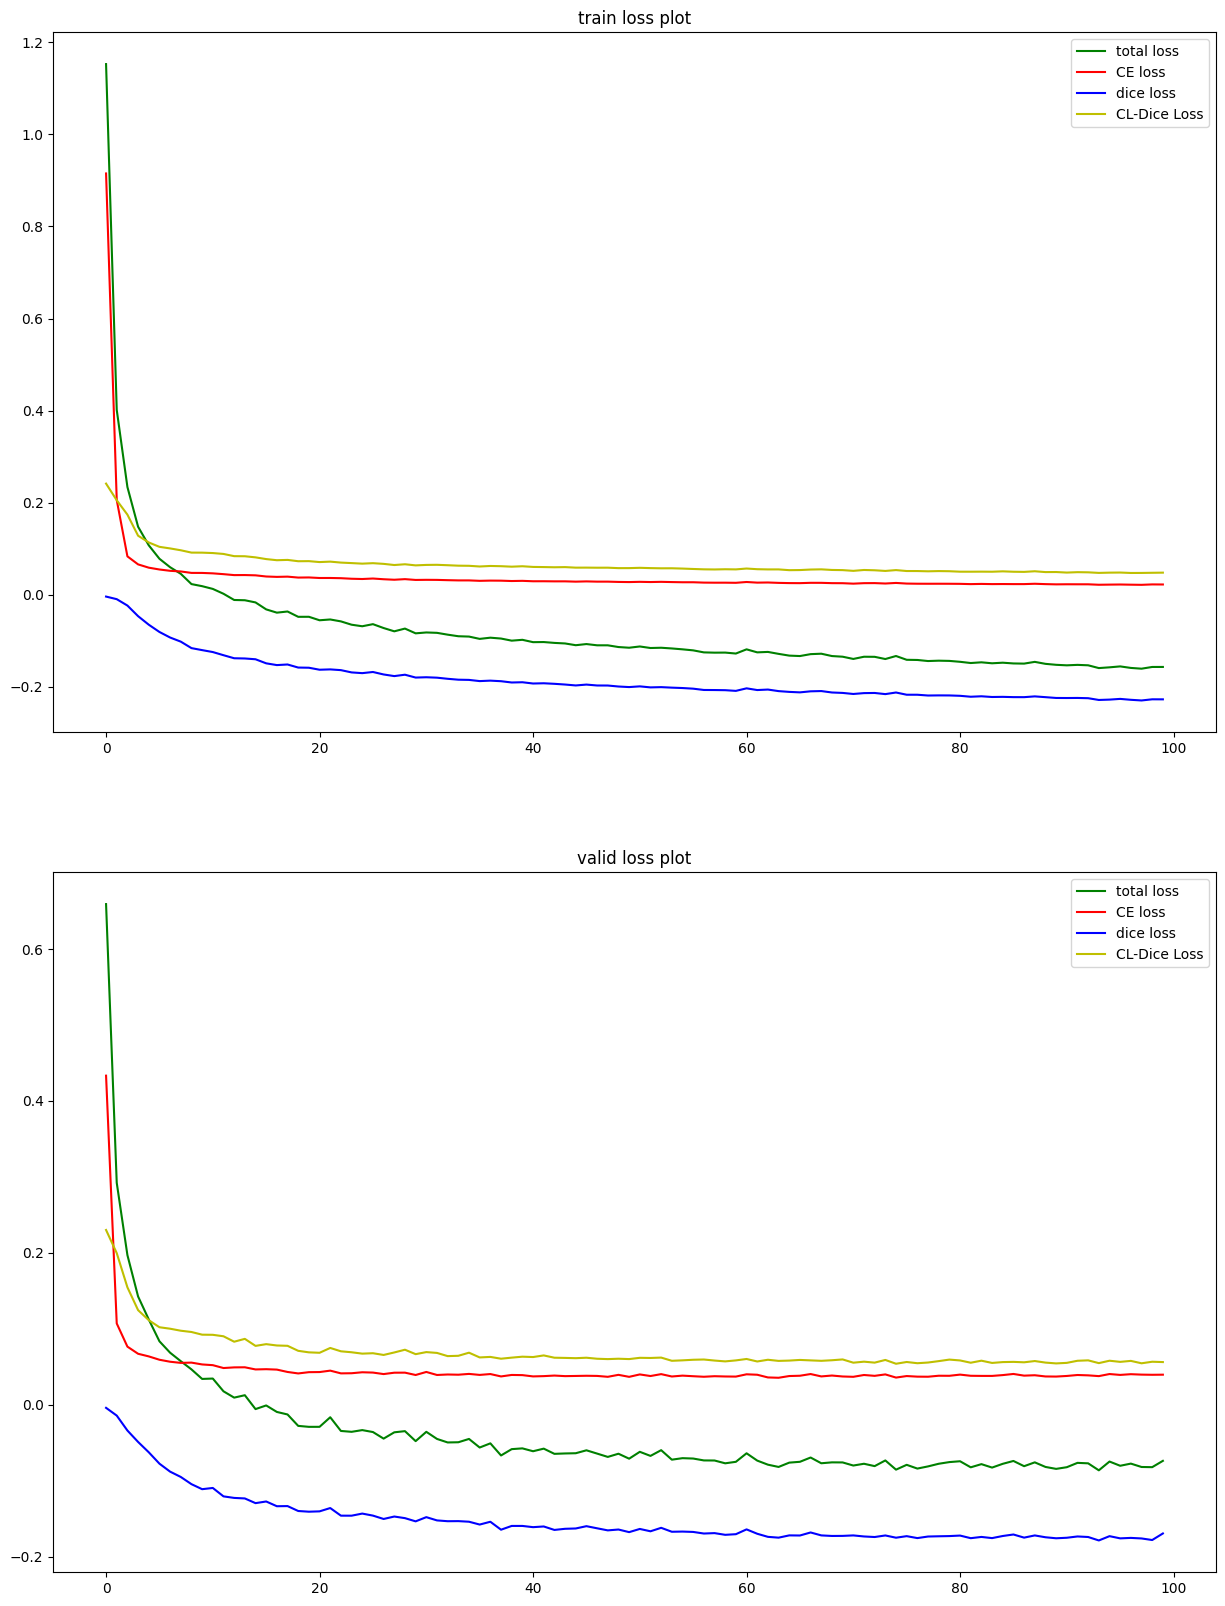

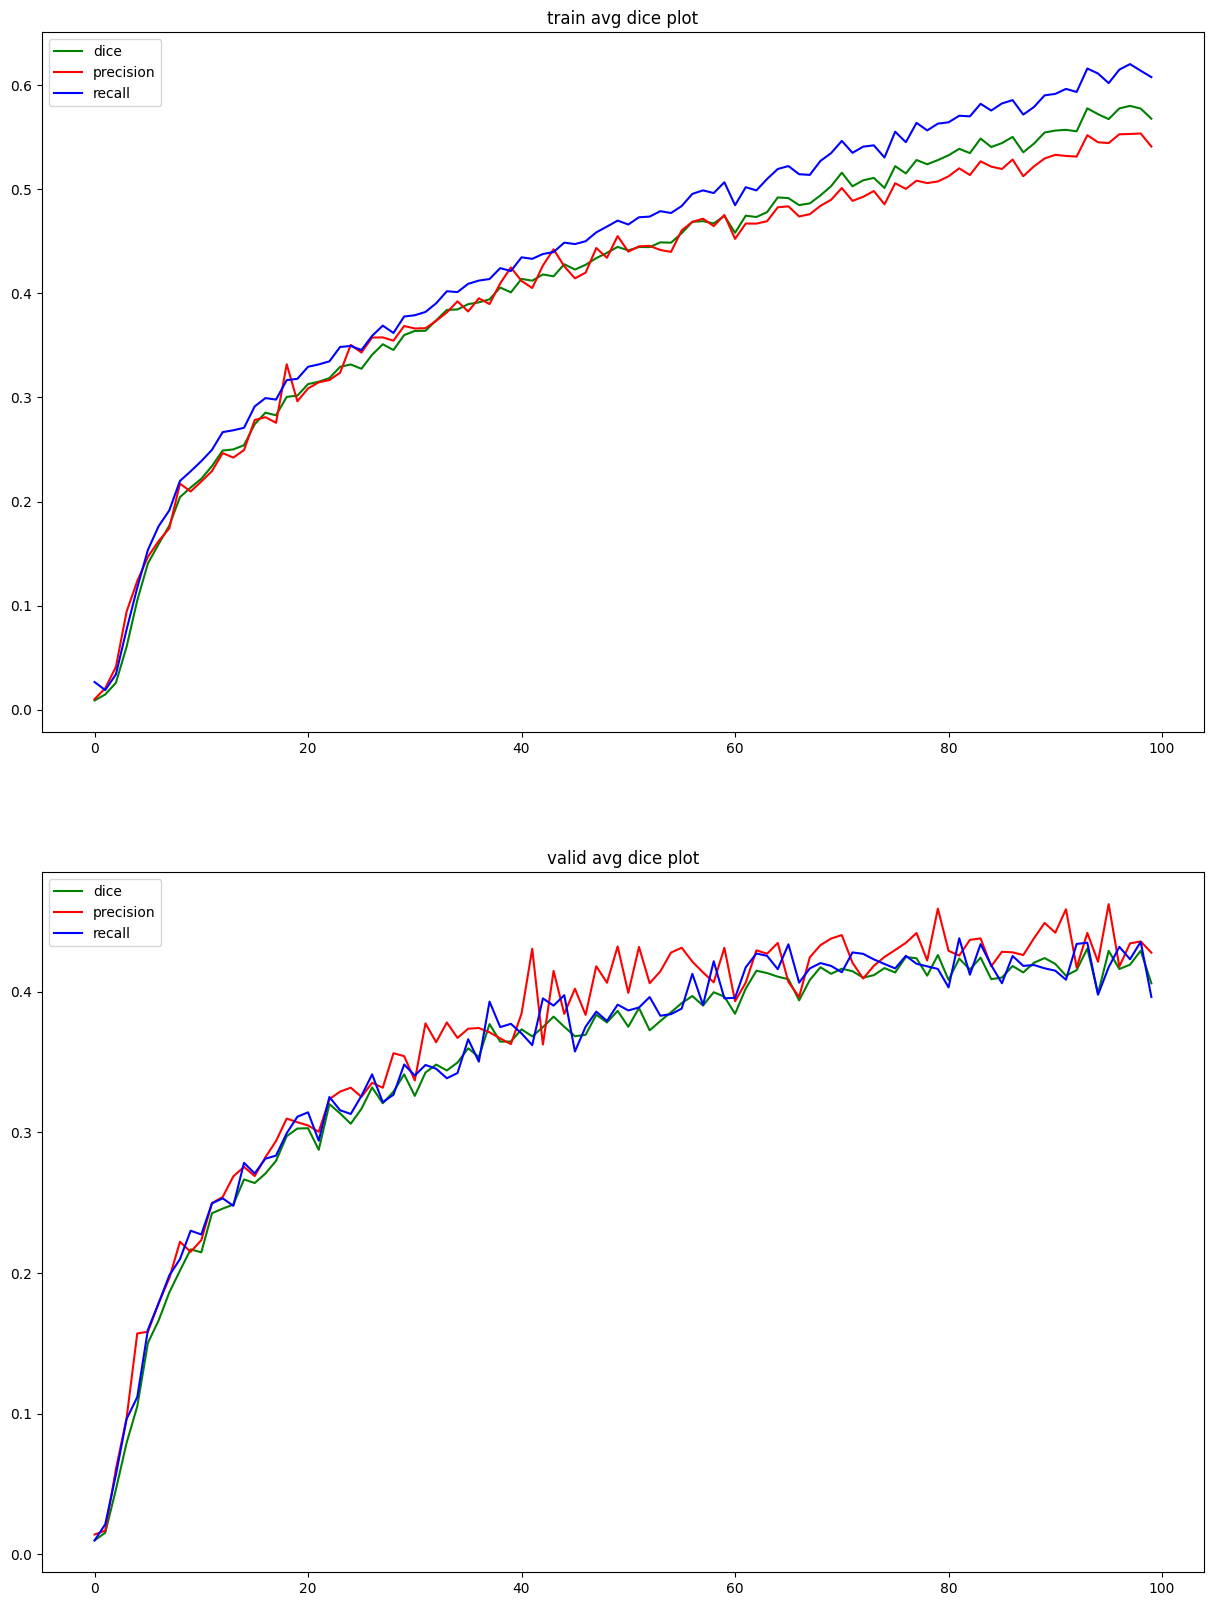

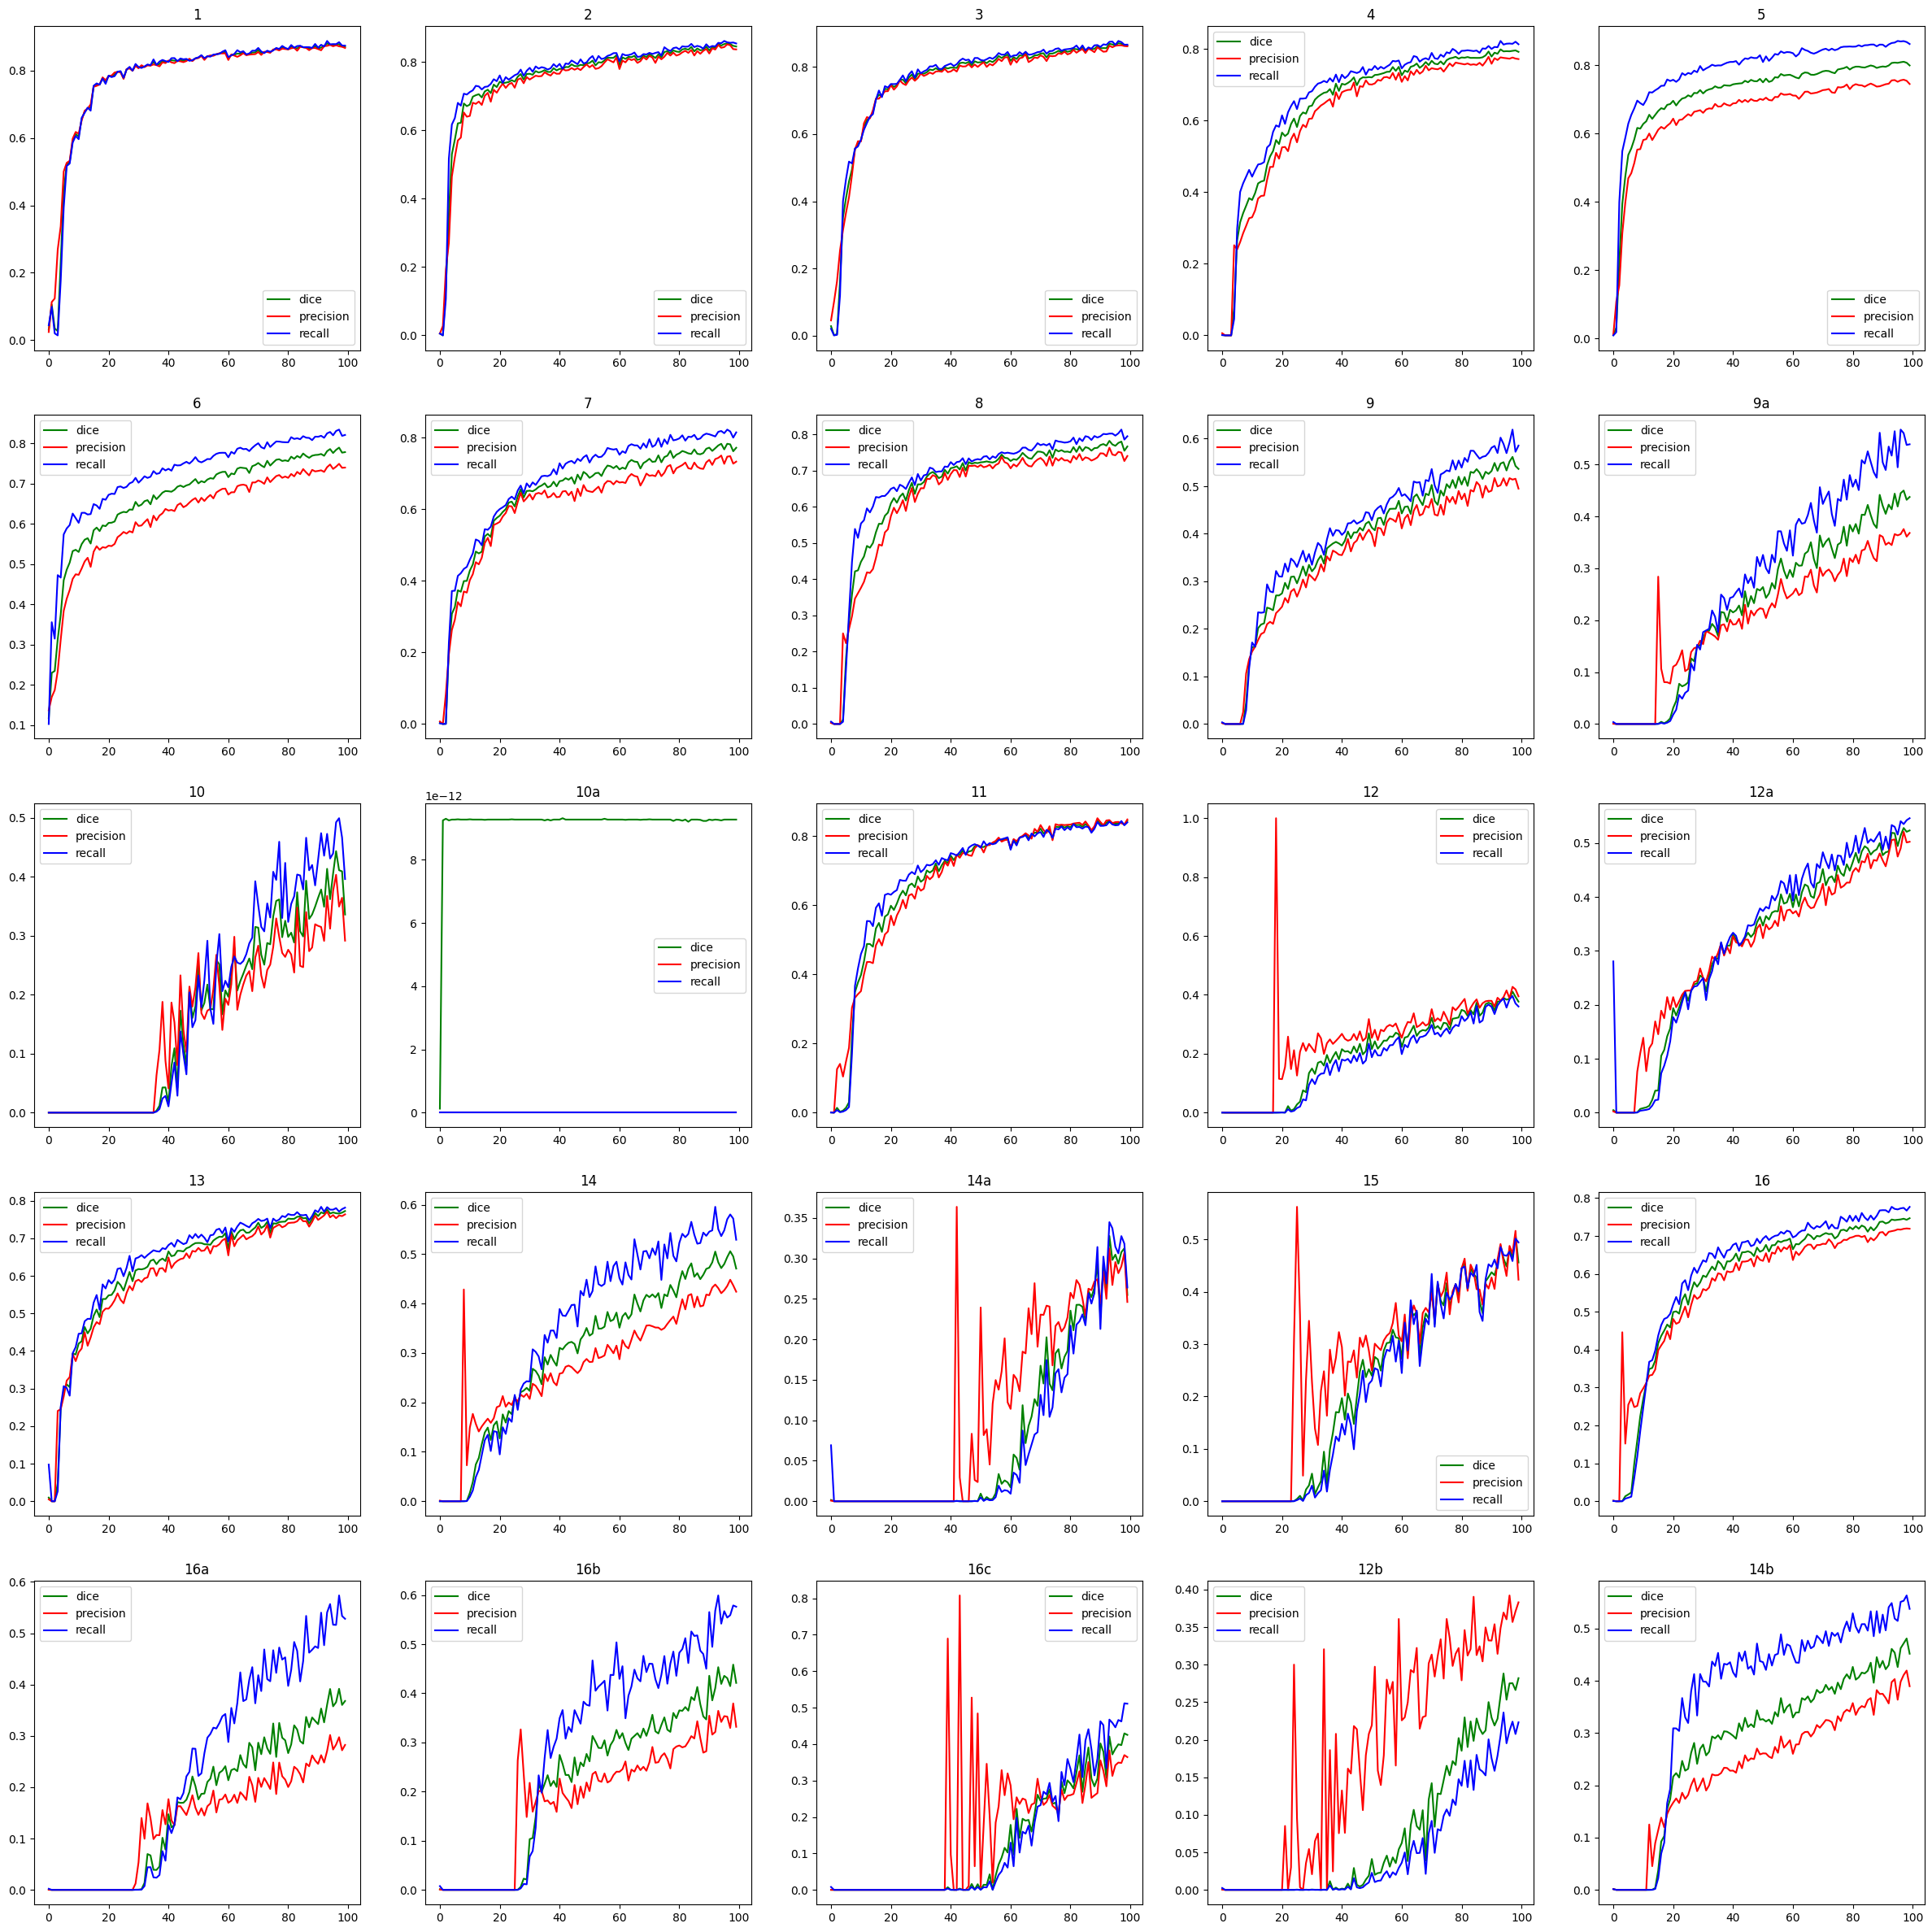

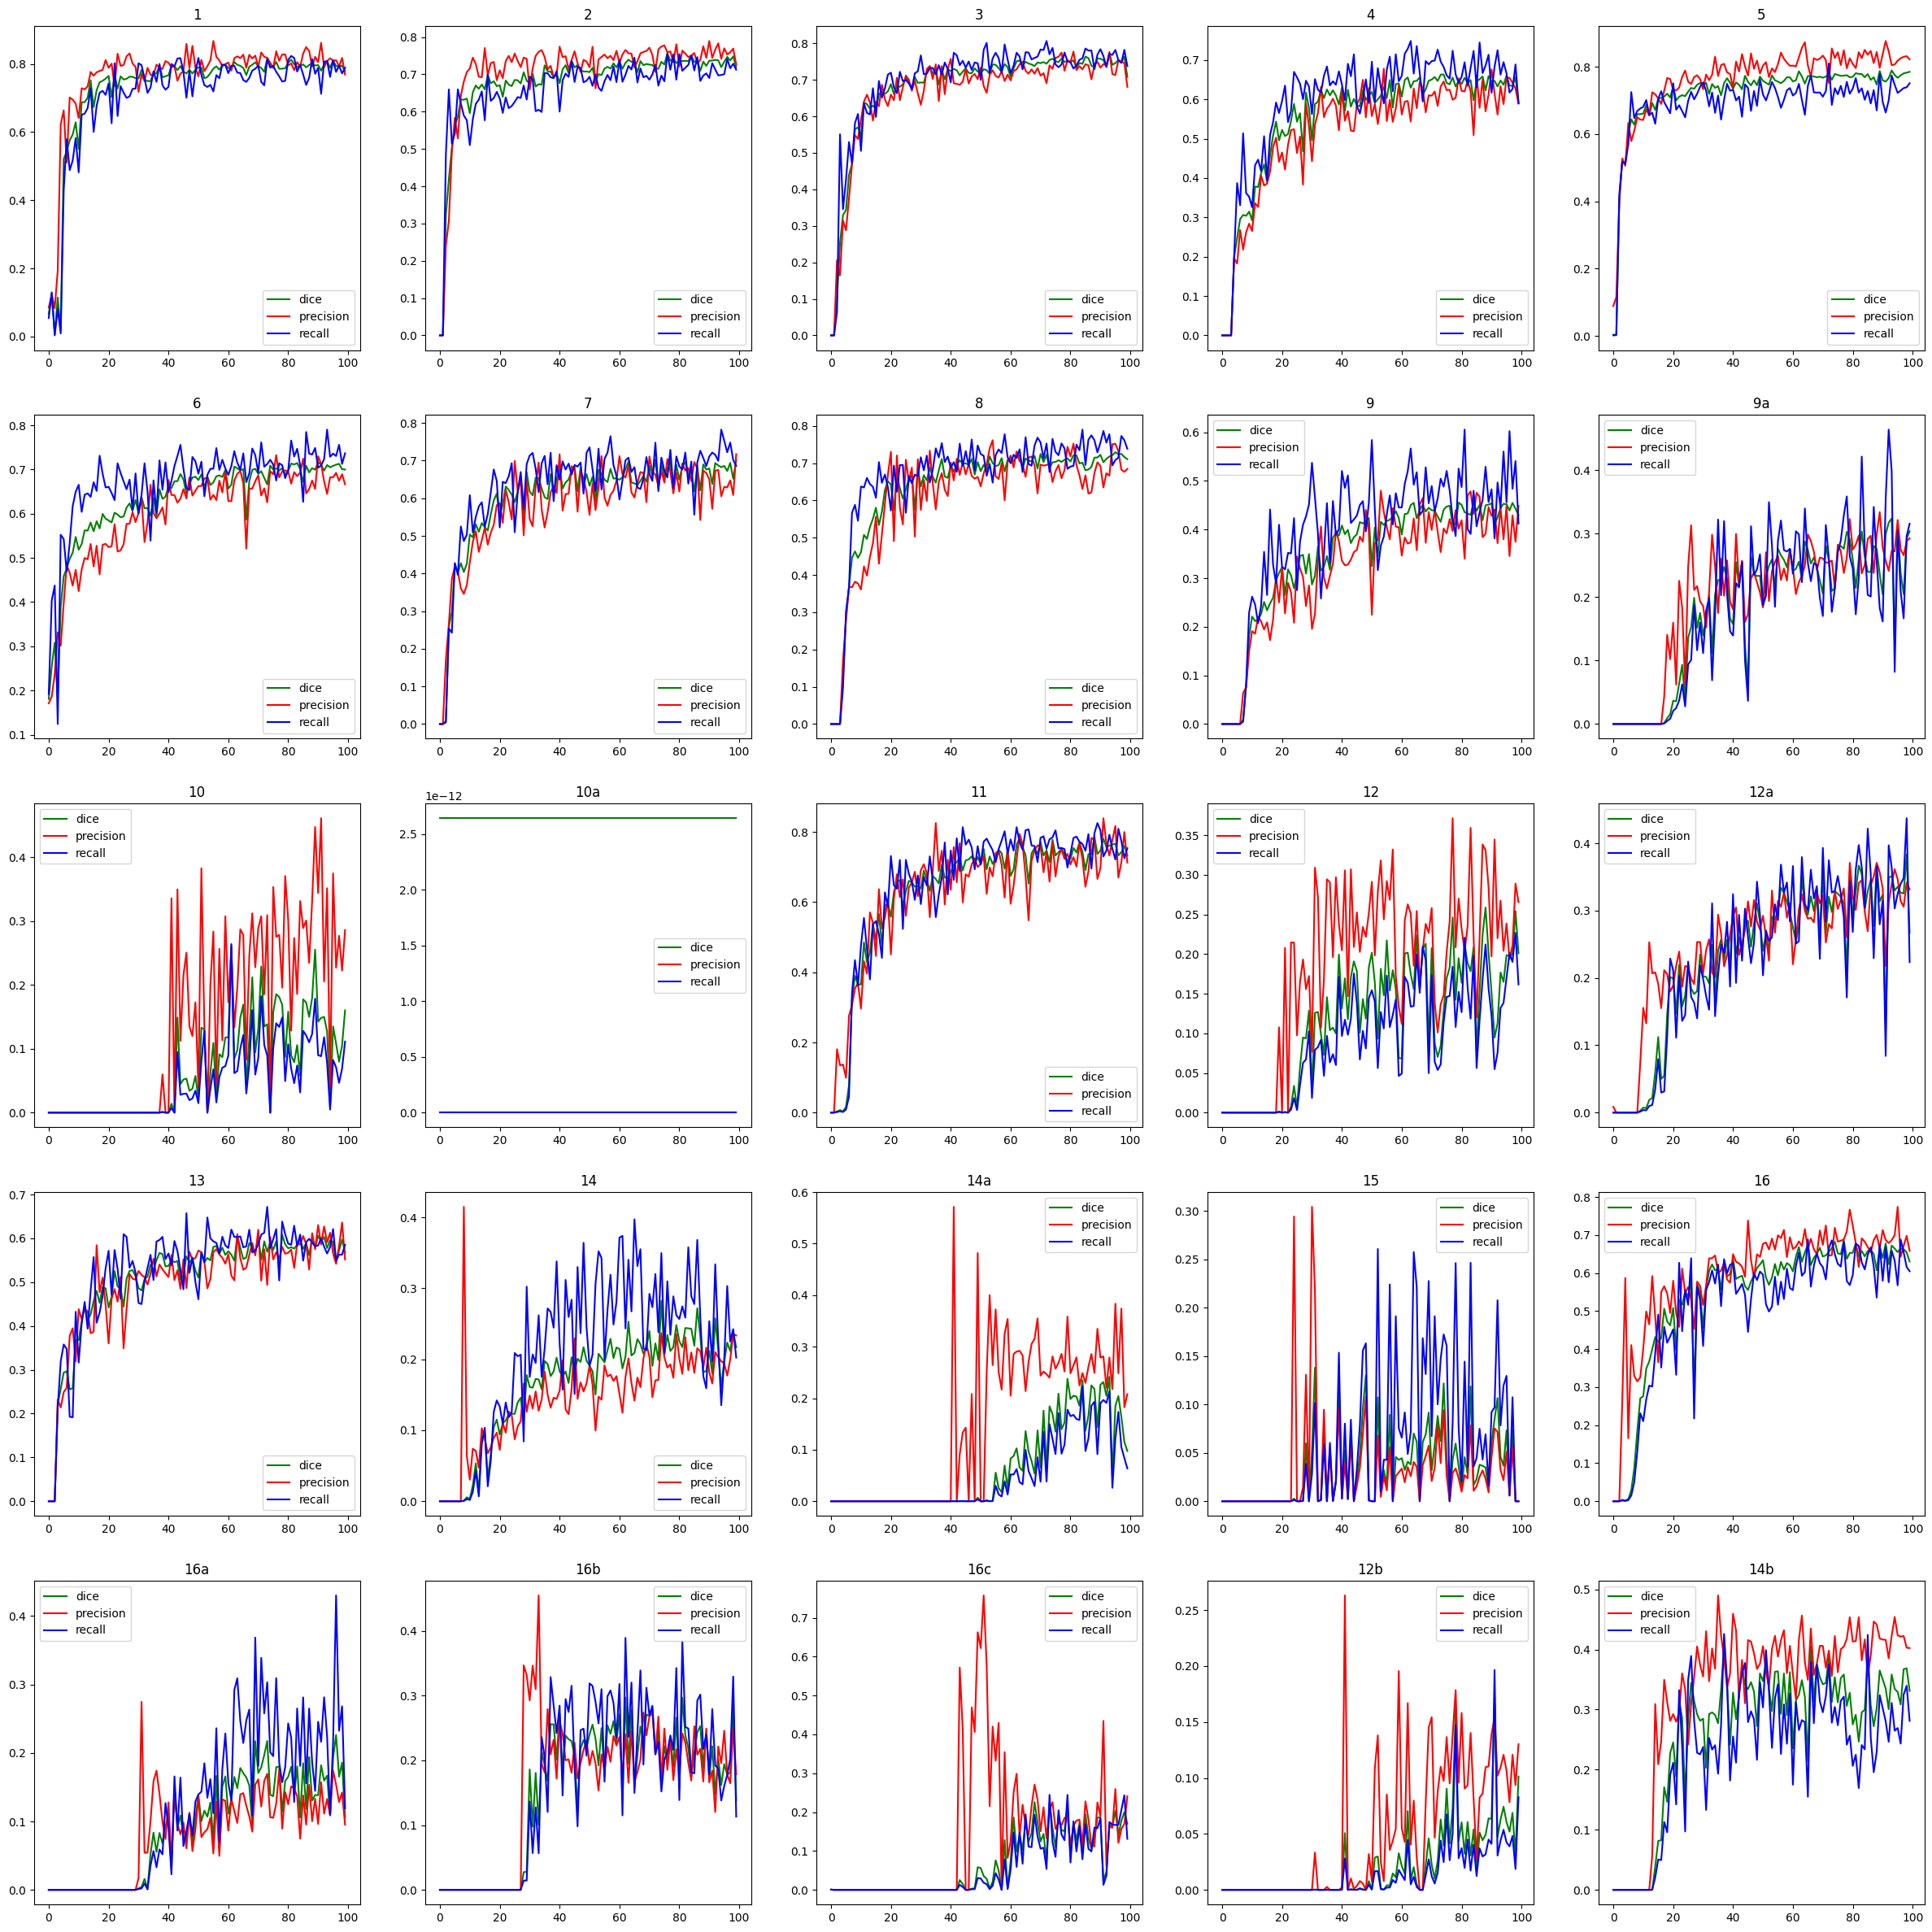

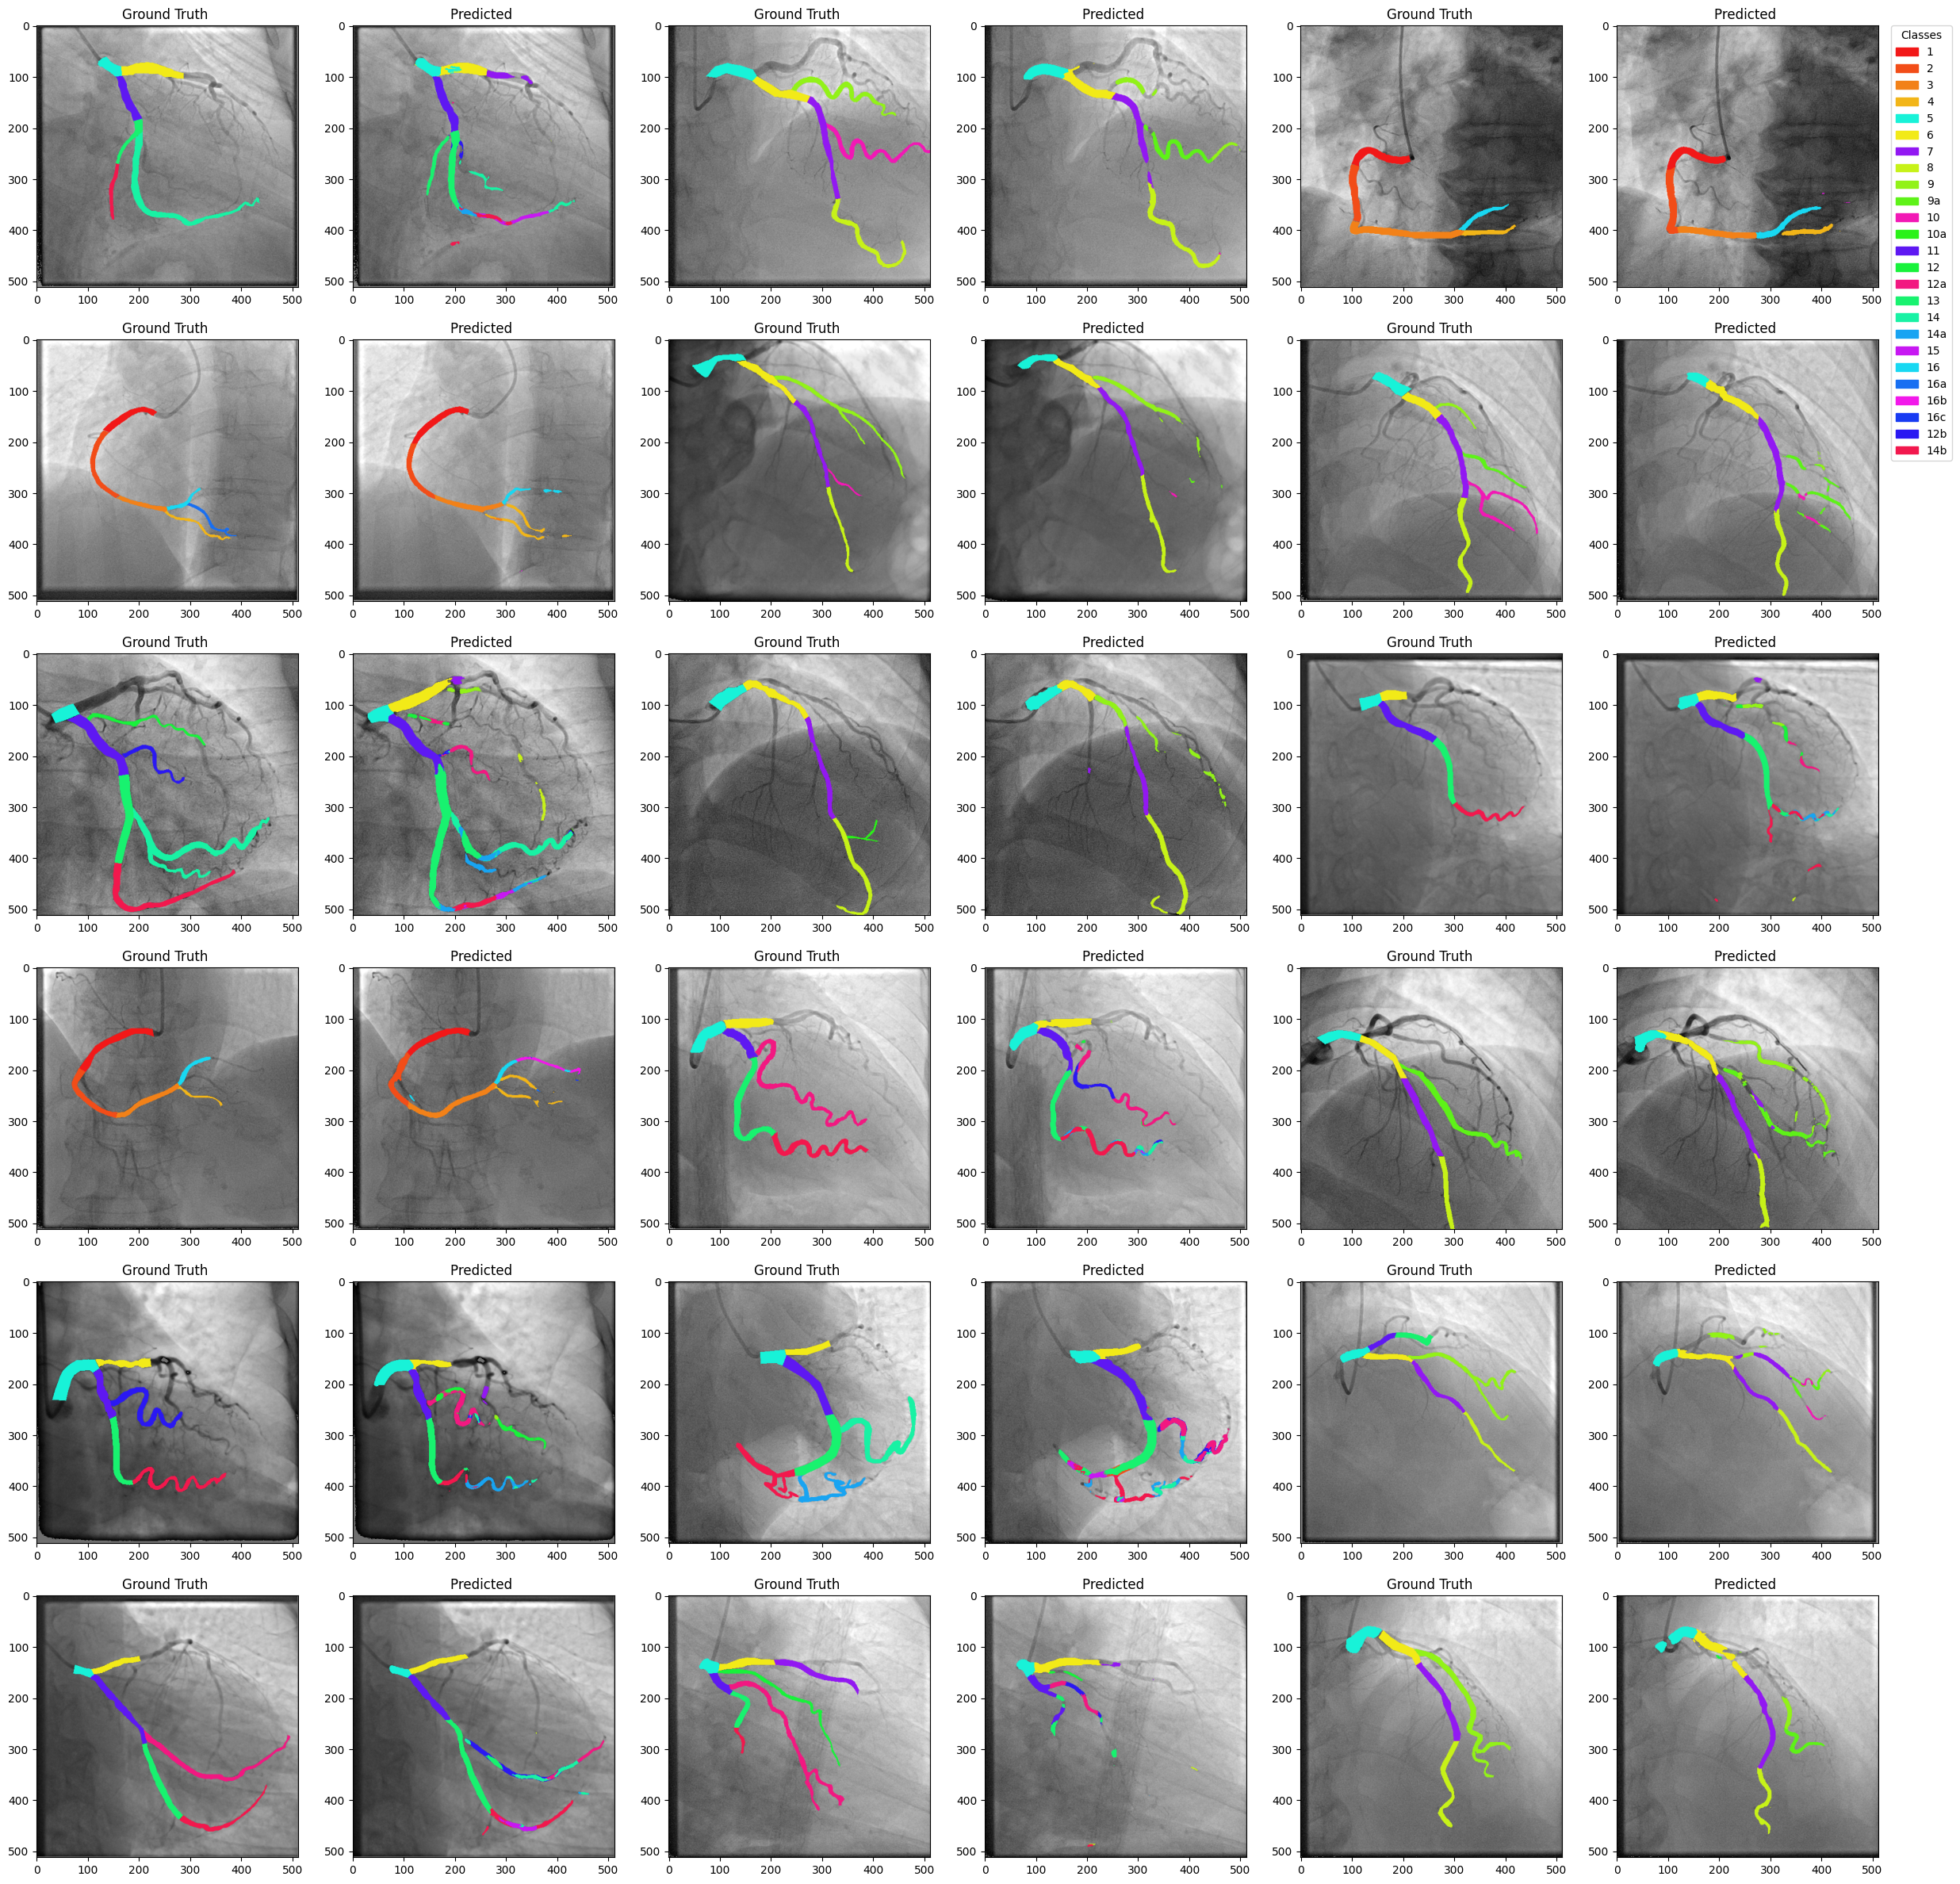

In [8]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)